# About the Data!

## Liquipedia
[Liquipedia](https://liquipedia.net) is a community platform that records all information e-sports. All data used in this project was obtained via [liquipedia's API](https://liquipedia.net/api-terms-of-use). This project conforms to the CC-BY-SA 3.0 license used for liquipedia content representation. For more information, visit: [Liquipedia:Copyrights](https://liquipedia.net/commons/Liquipedia:Copyrights). 

## Melee Tournaments Portal
Liquipedia currently stores data for over 900 professional smash Melee tournaments and is updating regularly. This project uses 973 tournaments ranging from locals to super majors to aggregate character information. While this list is not comprehensive, it is one the best unifed databases for melee events I could find. Alternatives: Smash.gg.

#### Tournaments can be classified into several categories:
1. Locals: low # participants, no out of state entrants, low prize pool, higher frequency, typically weekly
2. Regionals: Variable # participants, medium prize pool, players from surrounding regions enter, lowish freq, monthly, or biannualy
3. Majors: High # participants, high prize pool, international representation, annual
4. SuperMajors: High # participants (with exceptions like summit), highest prize pool, many of top 100 in attendance, annual (not guaranteed)

#### Players can be classified into:
1. Top 100 ranked
2. Unrated
3. Rated players can be weighted based on their point score in the top 100 rank


#### Initial concerns with the data:
1. Falcon beats Sheik:
    1. As a falcon main, I understand both the subjective struggles and the community held belief that Falcon has a losing matchup versus Sheik. 
2. Jigglypuff reigns supreme:
    1. According to this data Jigglypuff is considered to have the best win and loss records out of all competitors. Despite there only being X players ever ranked top 100 with her out of 13 years of play.
    
** The above data points suggest that raw performance of each character are not an accurate reflection of that character's viability but are influenced by an outlier % of the top-skilled, high-ranking playerbase.**





In [68]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas import Series
import pandas as pd
from pandas import DataFrame
from matplotlib import rcParams
%matplotlib inline


rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# Questions I want to answer:

###  Character usage:
1. ** <span style="color:green">Total matches of each char</span>**
    1. Answer: Fox is the guy
2. **<span style="color:green">Total players for each char</span>**
    1. Surprisingly it seems that there are a lot of falco players, but less matches for them
3. Compare ratio of players to total matches

###  Character win rate raw:
1. **<span style="color:green">Total win/loss of each char</span>**
    1. Matrix based matchup chart? raw
2. Character win rates are not a suitable way of measuring character superiority:
    1. Low tier characters with very few numbers of games often have one or two wins over a high tier giving them a 70:30 record, which just ain't right. 


### ***Weighted* character win rate**
1. Compare tournament year with the ssbm rank for that year and check if any of the players are top 100
2. Weight players based on their top 100 points vs their opponent's 

### Stage Usage and win rate for each character
1. Weighted as an aggregate of the total games played, thus all stage win ratios will add to 1
2. Weight only based on win/loss weighted ratio similar to weighted character win rate

# The Goal:
Create an image like this that isn't outdated and wildly off the mark:


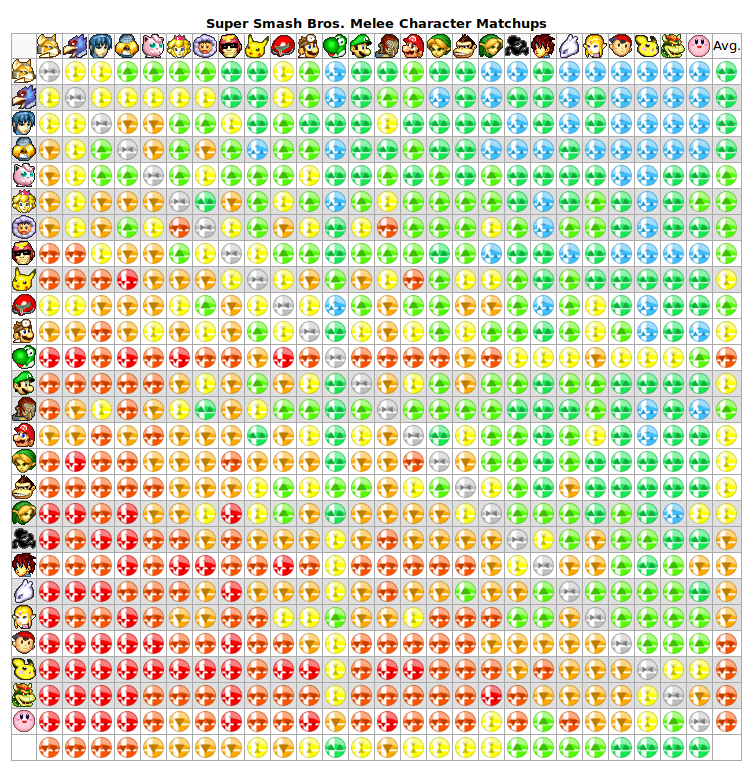

https://www.ssbwiki.com/Character_matchup_(SSBM)

In [69]:
conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()

# Character usage:

# List of characters
all_characters = ['DrMario', 'Mario', 'Luigi', 'Bowser', 'Peach', 'Yoshi', 'DonkeyKong', 'CaptainFalcon', 'Ganondorf', 'Falco', 'Fox', 'Ness', 'IceClimbers', 'Kirby', 'Samus', 'Zelda', 'Sheik', 'Link', 'YoungLink', 'Pichu', 'Pikachu', 'Jigglypuff', 'Mewtwo', 'GameandWatch_Logo_S', 'Marth', 'Roy']

# Data for all recorded matches
all_matches = c.execute("""SELECT * FROM MUs""")

# Total matches recorded
total = c.execute("""SELECT MID FROM MUs ORDER BY MID DESC""").fetchone()
total = list(total)[0]

# Dictionary of characters and their usage for plotting
char_usage = {}
uchar_usage = {}


tot = 0
# Isolate all P1chars and P2chars from all matches by character, find length
for char in all_characters:
    char += '('
    char_matches = c.execute("""SELECT P1name FROM MUs WHERE P1char LIKE '%{}%'""".format(char))
    char_matches2 = c.execute("""SELECT P2name FROM MUs WHERE P2char LIKE '%{}%'""".format(char))
    
    # The names attached to each match with a player of the specified char
    names = char_matches.fetchall()
    names2 = char_matches2.fetchall()
    all_names = names + names2

    # all instances of the char played via list of their players
    players = [str(list(elem)[0]) for elem in all_names]
    if 'BYE' in players:
        players.remove('BYE')

    # only instances of the character played by a unique player via set of their players
    uplayers = set(players)

    
    # total char usage
    total_char = len(players)
    # total unique char usage
    utotal_char = len(uplayers)
    
    char = char[:-1]
    
    char_usage[char] = total_char
    uchar_usage[char] = utotal_char
    
    print(f'# of {char} matches:' + str(total_char))
    tot += total_char
    
print(tot)
c.close()

# of DrMario matches:105
# of Mario matches:183
# of Luigi matches:447
# of Bowser matches:5
# of Peach matches:1903
# of Yoshi matches:365
# of DonkeyKong matches:62
# of CaptainFalcon matches:2775
# of Ganondorf matches:212
# of Falco matches:3358
# of Fox matches:9354
# of Ness matches:7
# of IceClimbers matches:1780
# of Kirby matches:3
# of Samus matches:1140
# of Zelda matches:2
# of Sheik matches:3565
# of Link matches:79
# of YoungLink matches:30
# of Pichu matches:1
# of Pikachu matches:432
# of Jigglypuff matches:1759
# of Mewtwo matches:16
# of GameandWatch_Logo_S matches:40
# of Marth matches:3435
# of Roy matches:12
31070


All matches are recorded as **P1name, P1char(W), stage, P2name, P2char(L), tournament**

Therefore when calculating total matches played, both p1 char and p2 char columns must be searched separately and added together:

## 1) RAW character usage:

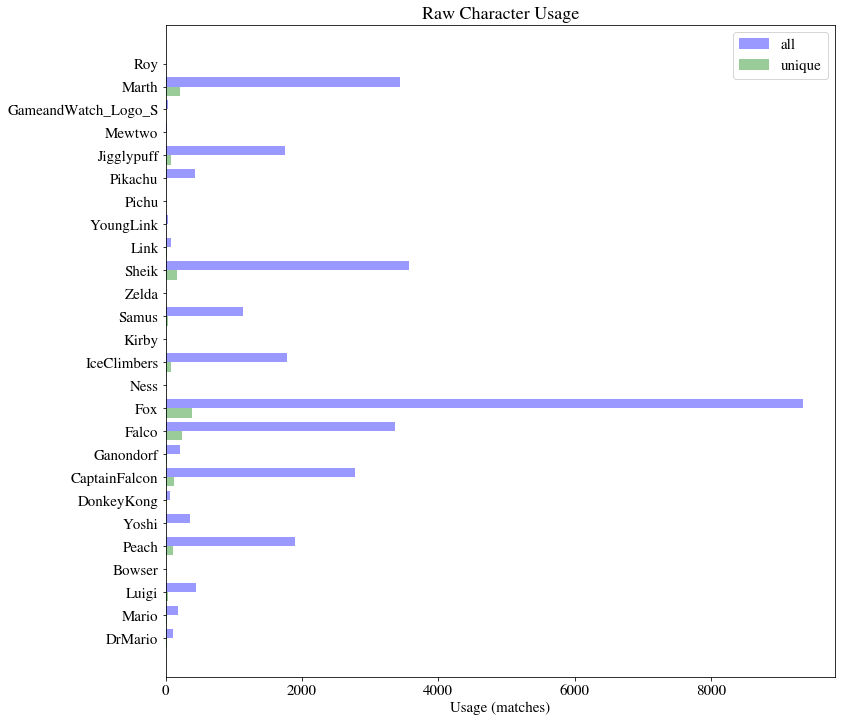

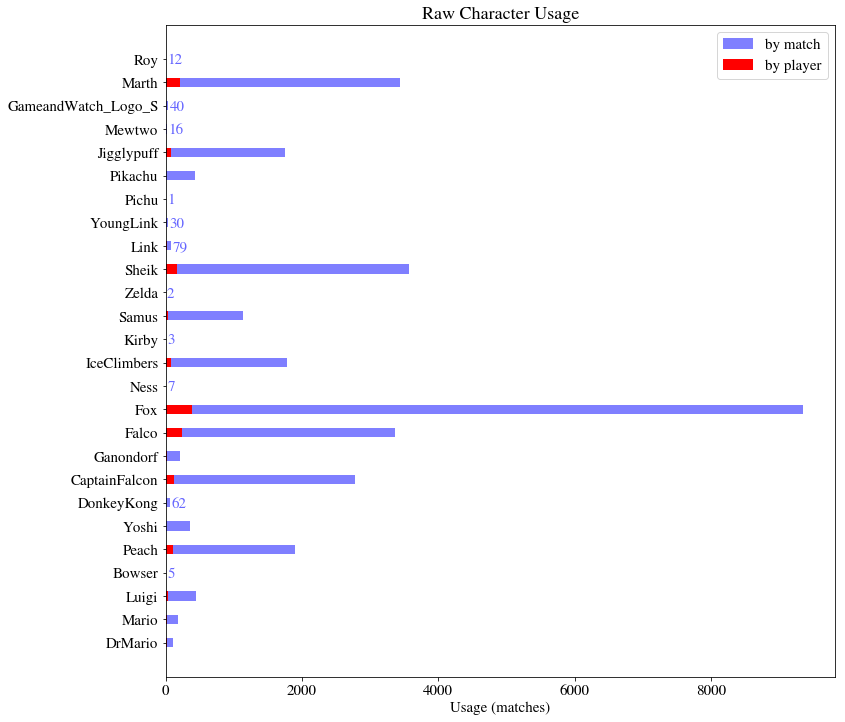

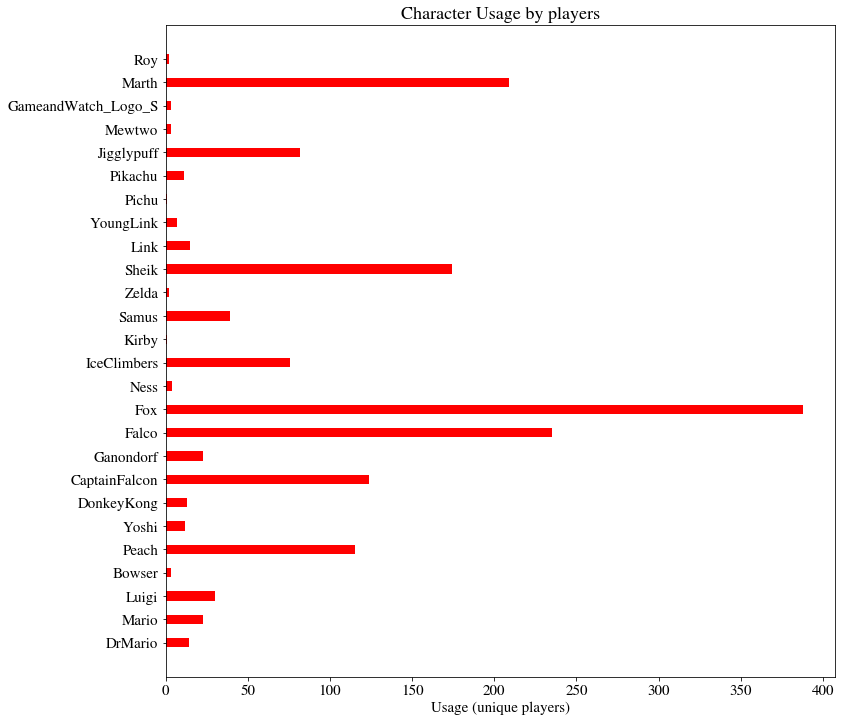

In [70]:
############ Raw Char Usage ############
chars = all_characters

# variables to plot
usage = [char_usage[i] for i in char_usage]
uusage = [uchar_usage[i] for i in uchar_usage]

# plot settings
y_pos = np.array([i for i, char in enumerate(chars)])
fig, ax = plt.subplots(figsize=(12,12),)
bar_width = .4
opacity = 0.4


# plot char usage by # matches
rects1 = plt.barh(y_pos + bar_width/2, usage, bar_width,
alpha=opacity,
color='b',
label='all')

# plot players using char
rects2 = plt.barh(y_pos - bar_width/2, uusage, bar_width,
alpha=opacity,
color='g',
label='unique')

plt.yticks(y_pos, chars)
plt.legend()
plt.xlabel('Usage (matches)')
plt.title('Raw Character Usage')


plt.show()


############ Raw Char Usage with overlap ############

# create figure and set bar vars
fig, ax = plt.subplots(figsize=(12,12),)
bar_width = .4
opacity = 0.5

# first series of bars
rects1 = plt.barh(y_pos, usage, bar_width,
alpha=opacity,
color='b',
label='by match')

# second series of bars
rects2 = plt.barh(y_pos, uusage, bar_width,
alpha=1,
color='r',
label='by player')
plt.yticks(y_pos, chars)
plt.legend()

# barlabels for small bars
for i, v in enumerate(usage):
    if v <= 100:
        ax.text(v + 20, i - .2, str(v), color='blue', alpha=.6)

# label and plot    
plt.xlabel('Usage (matches)')
plt.title('Raw Character Usage')
plt.show()



############ Characters by Players ############

# create figure and set bar vars
fig, ax = plt.subplots(figsize=(12,12),)
bar_width = .4
opacity = 0.5

# second series of bars
rects2 = plt.barh(y_pos, uusage, bar_width,
alpha=1,
color='r')
plt.yticks(y_pos, chars)


# label and plot    
plt.xlabel('Usage (unique players)')
plt.title('Character Usage by players')
plt.show()


This plot tells me that the number of players maining these characters is far smaller than the number of matches that involve the characters. It would be interesting to see if the ratio of total players is similar to the match distribution.

# 2) Win/Loss Ratio

In [71]:
# enter two characters, find the win loss ratio between them and the stages they most commonly win on
conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()
def ratio(char1, char2):
    wins = 0
    losses = 0

    # query all matches in the db
    query_matches = """SELECT P1name, P1char, Stage, P2name, P2char FROM `MUs` WHERE `P1char` LIKE ? 
    AND `P2char` LIKE ? ORDER BY `_rowid_` ASC LIMIT 0, 50000"""
    matchup = ('%' + char1 + '(%', '%' + char2 + '(%')
    rmatchup = matchup[::-1]

    bf = [0,0]
    dl = [0,0]
    ys = [0,0]
    fod = [0,0]
    ps = [0,0]
    fd = [0,0]
    stage_win = []
    stage_loss = []

    for match in c.execute(query_matches, matchup):
        if match[1] == char1 + '(W)':
            wins += 1
            stage_win.append(match[2])
        if match[1] == char1 + '(L)':
            losses += 1
            stage_loss.append(match[2])

    for match in c.execute(query_matches, rmatchup):
#         print(match)
        if match[4] == char1 + '(W)':
            wins += 1
            stage_win.append(match[2])
        if match[4] == char1 + '(L)':
            losses += 1
            stage_loss.append(match[2])
    try:
        p1_ratio = round((wins / (wins + losses)) * 100)
        p2_ratio = 100 - p1_ratio


    except ZeroDivisionError:
        p1_ratio = None
        p2_ratio = None

    print("\n\n{} vs {}\n {} wins: {}, losses: {} \n {} {}:{} {}".format(char1, char2, char1, wins, losses, char1, p1_ratio, p2_ratio, char2))
#     print(stage_loss)

    for stage in stage_loss:
        if stage == "Battlefield":
            bf[0] += 1
        if stage == "Dream Land":
            dl[0] += 1
        if stage == "Fountain of Dreams":
            fod[0] += 1
        if stage == 'Pokémon Stadium':
            ps[0] += 1
        if stage == "Final Destination":
            fd[0] += 1
        if stage == "Yoshi's Story":
            ys[0] += 1

    for stage in stage_win:
        if stage == "Battlefield":
            bf[1] += 1
        if stage == "Dream Land":
            dl[1] += 1
        if stage == "Fountain of Dreams":
            fod[1] += 1
        if stage == 'Pokémon Stadium':
            ps[1] += 1
        if stage == "Final Destination":
            fd[1] += 1
        if stage == "Yoshi's Story":
            ys[1] += 1

#     try:
#         print(f'{char1} Final Destination win val: {(100 * fd[1] / (fd[1] + fd[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Pokemon Stadium win val: {(100 * ps[1] / (ps[1] + ps[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Yoshi Story  win val: {(100 * ys[1] / (ys[1] + ys[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Fountain  win val: {(100 * fod[1] / (fod[1] + fod[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Dream Land  win val: {(100 * dl[1] / (dl[1] + dl[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Battlefield  win val: {(100 * bf[1] / (bf[1] + bf[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
    # staged = {"Battlefield" : bf, "Dreamland": dl, "Fountain of Dreams": fod, "Pokémon Stadium": ps, "Yoshi's Story": ys}
    # for i in staged:
    #     print(staged[i])

ratio('Falco', 'Fox')

c.close()



Falco vs Fox
 Falco wins: 1016, losses: 1026 
 Falco 50:50 Fox


In [72]:
conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()

def winloss(char):

    wins = 0
    losses = 0

    # query all wins
    q1 = """SELECT `_rowid_`,* FROM `MUs` WHERE P1name NOT LIKE '%BYE%' AND P1char LIKE ? AND P2name NOT LIKE '%BYE%' AND P2char NOT LIKE ? ORDER BY P1name ASC LIMIT 0, 50000;"""
    q2 = """SELECT `_rowid_`,* FROM `MUs` WHERE P1name NOT LIKE '%BYE%' AND P1char NOT LIKE ? AND P2name NOT LIKE '%BYE%' AND P2char LIKE ? ORDER BY `P2name` ASC LIMIT 0, 50000;"""
    character = ('%' + char + '(%', '%' + char + '(%')
    character_wins = ('%' + char + '(W%', '%' + char + '(W%')

    
    total_matches = len(c.execute(q1, character).fetchall()) + len(c.execute(q2, character).fetchall())
    wins = len(c.execute(q1, character_wins).fetchall()) + len(c.execute(q2, character_wins).fetchall())
    ratio = wins / total_matches
    print(f'{char}: {total_matches}, wins: {wins}, ratio: {ratio}')
    return ratio

win_ratio = {}

for char in chars:
    win_ratio[char] = winloss(char)

print(win_ratio)
c.close()


DrMario: 197, wins: 83, ratio: 0.4213197969543147
Mario: 299, wins: 120, ratio: 0.4013377926421405
Luigi: 768, wins: 326, ratio: 0.4244791666666667
Bowser: 6, wins: 0, ratio: 0.0
Peach: 3997, wins: 2177, ratio: 0.5446584938704028
Yoshi: 789, wins: 426, ratio: 0.5399239543726235
DonkeyKong: 97, wins: 44, ratio: 0.4536082474226804
CaptainFalcon: 5147, wins: 2792, ratio: 0.542451913736157
Ganondorf: 359, wins: 166, ratio: 0.4623955431754875
Falco: 5888, wins: 3090, ratio: 0.524796195652174
Fox: 13856, wins: 9423, ratio: 0.6800663972286374
Ness: 16, wins: 6, ratio: 0.375
IceClimbers: 3108, wins: 1577, ratio: 0.5074002574002574
Kirby: 9, wins: 5, ratio: 0.5555555555555556
Samus: 2232, wins: 1077, ratio: 0.4825268817204301
Zelda: 9, wins: 4, ratio: 0.4444444444444444
Sheik: 6223, wins: 3576, ratio: 0.5746424554073598
Link: 119, wins: 38, ratio: 0.31932773109243695
YoungLink: 45, wins: 13, ratio: 0.28888888888888886
Pichu: 3, wins: 1, ratio: 0.3333333333333333
Pikachu: 905, wins: 503, ratio: 

## RAW win rate:

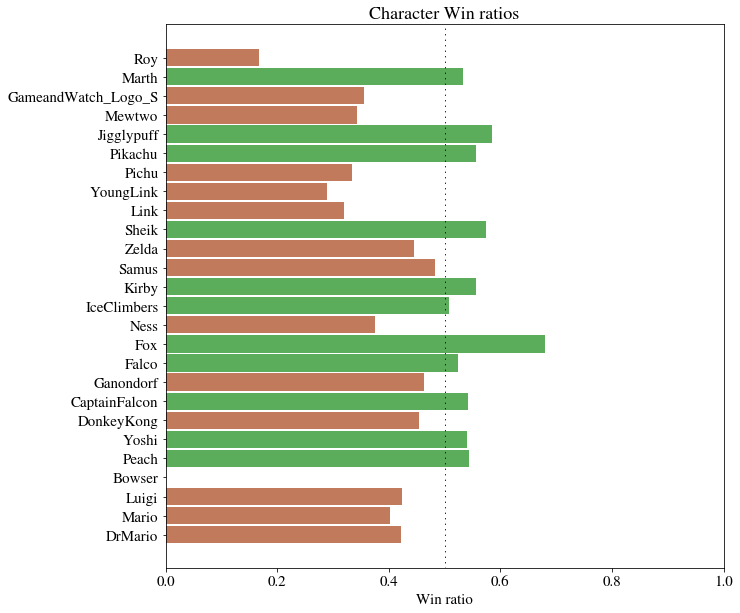

In [73]:
# set positions for yticks/labels
y_pos = np.array([i for i, char in enumerate(chars)])

ratio = [win_ratio[i] for i in win_ratio]

# create figure and set bar vars
fig, ax = plt.subplots(figsize=(10,10),)
bar_width = .9
opacity = 0.4

# first series of bars
rects1 = plt.barh(y_pos, ratio, bar_width,
alpha=opacity,
color='g')



# plot bar graph and change color for ratios worse than even
for i, pos in enumerate(y_pos):
    if ratio[i] < .5:
        color = 'r'
    else:
        color = 'g'
    plt.barh(pos, ratio[i], bar_width, alpha=opacity, color=color)

# add dotted line at .5 ratio
plt.axvline(x=.5, linewidth=1, color='black', dashes=(0.5, 5.), dash_capstyle = 'round')

# set the min/max values for figure
ax.set_xlim([0,1])

# plt the ticks and y values
plt.yticks(y_pos, chars)


# label and plot    
plt.xlabel('Win ratio')
plt.title('Character Win ratios')
plt.show()



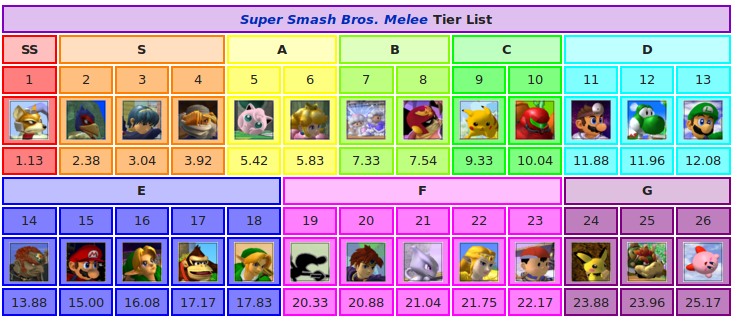
<span style="center" color="blue">Image taken from: https://www.ssbwiki.com/List_of_SSBM_tier_lists_(NTSC)</span>

This dataset is pretty funny. It gives me a taste that large datasets can yield real insight with predictive capabilities, but in the same fell swoop, are absurd without fine tuning. When looking at these results it is interesting to note that **the top 9 characters of the 2015 ssbm wiki tier list**, a rating system measuring viability of tournament play for each character determined by a panel of respected players and analysts, ***near exclusively* perform with a positive win/loss record**. This would support the belief that the dataset is a robust measurement of the characters' *viability* as it matches the community standards for the best characters' predicted performance. *However,* there is one major issue with the results. **Kirby**. Kirby appears to have one of the top 5 highest win ratios, while ranked firmly at the bottom of the tier list. In recent years debate has suggested kirby's placement is too low, but this new placement is still within the bottom 5, much less the top 5. Based on this evidence, it appears that the data has some predictive power but is ultimately problematic. 

Let's explore that.

## Problems with data:

#### 1) Low Tiers: Low Sample Size
The immediate concern I have with kirby and most of the other lower tiers comes from char usage by match of Figure 1. It seems that the knowledge imparted by this tier list is either self-evident in tournament play or has been followed so religiously that all tournament players solely main characters from the higher tiers. After Captain Falcon there is a steep drop off in the number of matches played for each lower tiered characted. By the time you reach Kirby... there are only 9 recorded games of kirby players in the data set. This low sample size causes any results to be much more prone to randomness.

##### Possible Solution: Focus only on characters with moderate to high usage.

#### 2) Player Skill DIfferentials
A second problem with this data set is that there are only uniform records of character matchups in the top 32's of bracket. This means that to even get to a point where a player and their character are reported they must have won their pools and preliminary bracket matches. This is where the majority of players drown in anonymity. Therefore the ones recorded by these visualizations are already in a certain subset of skill: quite higher than the average ssbm tournament attendant.

This context adds another possible interpretation of the data, that the low usage of some characters is not actually a representation of their usage but a representation of their lower skill ceilings, indicating that they did not make it to the end of their bracket. However, it is likely a mix of several factors.

##### Possible solution: Weight ranked players, or ignore unranked players. Find mu's of top players off of their mean w/l ratio. 
1. Weight players that play matches based on ssbmrank. High rank differential wins mean less value attributed to the character's win over another.

2. Look into top players' win loss record vs other top players. This sample size may be smaller but could reduce the amount of player skill differentials. It also would be interesting to see the top players' ability to push the envelope with a character and then determine the relative percent of win/loss score around the mean w/l ratio they have to determine positive and negative matchups. 


In [141]:
# Let's see if we can join a player match to the player's ranking and points if they exists


conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()

def winloss(char):
    print("Don't worry, it's running...")

    # query all matches
    match = """SELECT P1name, P2name, Tournament, Name, Date FROM [MUs] JOIN TOURNAMENTS ON [MUs].Tournament = Tournaments.Name;
    """
    matchdf = pd.read_sql_query(match, conn)
      
    # take names from matches and the date they occurred    
    for index in matchdf.index:
        name1 = matchdf.loc[index, "P1name"]
        name2 = matchdf.loc[index, "P2name"]
        period = matchdf.loc[index, "Date"]
        
        # format the date into a year that aligns with the SSBMRANK table's Year
        def period_parse(period):
            month = period[0:3]
            year = period[-4:]
            summer = ["Jun", "Jul", "Aug", "Sep"]
            if month in summer:
                year += "_Summer"
            return year
        match_year = period_parse(period)
        
        # query ssbmranks for any player names that are in the top 100 for the year the match was played
        ssbmrank = """SELECT Rank, Name, Points FROM SSBMRANK WHERE Name LIKE "{}" AND Year LIKE "{}" OR Name Like "{}" AND Year LIKE "{}";""".format(name1, match_year, name2, match_year)
        rankdf = pd.read_sql_query(ssbmrank, conn)
        if len(rankdf.index) >= 1:
            name1 = rankdf.values[0][1]
            rank1 = rankdf.values[0][0]
            points1 = rankdf.values[0][2]
            
            name2 = None
            rank2 = None
            points2 = None
            if len(rankdf.index) == 2:
                name2 = rankdf.values[1][1]
                rank2 = rankdf.values[1][0]
                points2 = rankdf.values[1][2]
            print(name1, rank1, points1, name2, rank2, points2)

winloss('Fox')
c.close()



Don't worry, it's running...
n0ne 29 66.9 None None None
n0ne 29 66.9 None None None
n0ne 29 66.9 None None None
n0ne 29 66.9 None None None
n0ne 29 66.9 None None None
S2J 9 88.6 Bimbo 39 53.9
S2J 9 88.6 Bimbo 39 53.9
S2J 9 88.6 Bimbo 39 53.9
S2J 9 88.6 Bimbo 39 53.9
S2J 9 88.6 Bimbo 39 53.9
Fiction 15 81.2 None None None
Fiction 15 81.2 None None None
Fiction 15 81.2 None None None
n0ne 29 66.9 None None None
n0ne 29 66.9 None None None
n0ne 29 66.9 None None None
MikeHaze 31 62.8 None None None
MikeHaze 31 62.8 None None None
MikeHaze 31 62.8 None None None
S2J 9 88.6 Fiction 15 81.2
S2J 9 88.6 Fiction 15 81.2
S2J 9 88.6 Fiction 15 81.2
S2J 9 88.6 Fiction 15 81.2
S2J 9 88.6 Fiction 15 81.2
n0ne 29 66.9 MikeHaze 31 62.8
n0ne 29 66.9 MikeHaze 31 62.8
n0ne 29 66.9 MikeHaze 31 62.8
n0ne 29 66.9 MikeHaze 31 62.8
SFAT 11 87.4 MikeHaze 31 62.8
SFAT 11 87.4 MikeHaze 31 62.8
SFAT 11 87.4 MikeHaze 31 62.8
SFAT 11 87.4 MikeHaze 31 62.8
SFAT 11 87.4 MikeHaze 31 62.8
Fiction 15 81.2 Captain Face

Mango 5 95.5 Zain 6 93.4
Mango 5 95.5 Zain 6 93.4
Mango 5 95.5 Zain 6 93.4
Mango 5 95.5 Zain 6 93.4
Spark 41 52.6 None None None
Spark 41 52.6 None None None
Medz 27 67.6 Spark 41 52.6
Medz 27 67.6 Spark 41 52.6
Medz 27 67.6 Spark 41 52.6
Captain Faceroll 17 80.0 None None None
Captain Faceroll 17 80.0 None None None
Captain Faceroll 17 80.0 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Spark 41 52.6 None None None
Spark 41 52.6 None None None
Spark 41 52.6 None None None
aMSa 8 91.3 Westballz 26 71.0
aMSa 8 91.3 Westballz 26 71.0
aMSa 8 91.3 Westballz 26 71.0
aMSa 8 91.3 Westballz 26 71.0
aMSa 8 91.3 Westballz 26 71.0
Captain Faceroll 17 80.0 None None None
Captain Faceroll 17 80.0 None None None
Captain Faceroll 17 80.0 None None None
Captain Faceroll 17 80.0 None None None
aMSa 8 91.3 Spark 41 52.6
aMSa 8 91.3 Spark 41 52.6
aMSa 8 91.3 Spark 41 52.6
aMSa 8 91.3 Spar

Leffen 4 96.7 None None None
Leffen 4 96.7 None None None
Leffen 4 96.7 None None None
Fiction 15 81.2 ChuDat 28 67.2
Fiction 15 81.2 ChuDat 28 67.2
Fiction 15 81.2 ChuDat 28 67.2
Fiction 15 81.2 ChuDat 28 67.2
Swedish Delight 13 83.5 Hax$ 25 71.2
Swedish Delight 13 83.5 Hax$ 25 71.2
Swedish Delight 13 83.5 Hax$ 25 71.2
Swedish Delight 13 83.5 Hax$ 25 71.2
Swedish Delight 13 83.5 Hax$ 25 71.2
Leffen 4 96.7 SFAT 11 87.4
Leffen 4 96.7 SFAT 11 87.4
Leffen 4 96.7 SFAT 11 87.4
Swedish Delight 13 83.5 ChuDat 28 67.2
Swedish Delight 13 83.5 ChuDat 28 67.2
Swedish Delight 13 83.5 ChuDat 28 67.2
Swedish Delight 13 83.5 ChuDat 28 67.2
Swedish Delight 13 83.5 ChuDat 28 67.2
Leffen 4 96.7 iBDW 10 88.5
Leffen 4 96.7 iBDW 10 88.5
Leffen 4 96.7 iBDW 10 88.5
Leffen 4 96.7 iBDW 10 88.5
Leffen 4 96.7 iBDW 10 88.5
moky 14 82.9 ChuDat 28 67.2
moky 14 82.9 ChuDat 28 67.2
moky 14 82.9 ChuDat 28 67.2
moky 14 82.9 ChuDat 28 67.2
moky 14 82.9 ChuDat 28 67.2
Hungrybox 1 99.8 S2J 9 88.6
Hungrybox 1 99.8 S2J 9 88

Jakenshaken 43 49.9 None None None
Jakenshaken 43 49.9 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Jakenshaken 43 49.9 None None None
Jakenshaken 43 49.9 None None None
Jakenshaken 43 49.9 None None None
Jakenshaken 43 49.9 None None None
Michael 47 45.3 None None None
Michael 47 45.3 None None None
Michael 47 45.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
Michael 47 45.3 None None None
Michael 47 45.3 None None None
Michael 47 45.3 None None None
Michael 47 45.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
KJH 21 75.3 None None None
Jakenshaken 43 49.9 Michael 47 45.3
Jakenshaken 43 49.9 Michael 47 45.3
Jakenshaken 43 49.9 Michael 47 45.3
Jakenshaken 43 49.9 Michael 47 45.3
Ginger 18 77.2 None None None
Ginger 18

Wizzrobe 2 98.7 iBDW 10 88.5
Wizzrobe 2 98.7 iBDW 10 88.5
Wizzrobe 2 98.7 iBDW 10 88.5
Wizzrobe 2 98.7 iBDW 10 88.5
Wizzrobe 2 98.7 SFAT 11 87.4
Wizzrobe 2 98.7 SFAT 11 87.4
Wizzrobe 2 98.7 SFAT 11 87.4
Hungrybox 1 99.8 Wizzrobe 2 98.7
Hungrybox 1 99.8 Wizzrobe 2 98.7
Hungrybox 1 99.8 Wizzrobe 2 98.7
Hungrybox 1 99.8 Wizzrobe 2 98.7
Hungrybox 1 99.8 Wizzrobe 2 98.7
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Lucky 23 71.7 None None None
Lucky 23 71.7 None None None
Lucky 23 71.7 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Lucky 23 71.7 None None None
Lucky 23 71.7 None None None
Lucky 23 71.7 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Ginger 18 77.2 None None None
Lucky 23 71.7 None None None
Lucky 23 71.7 None None None
Lucky 23 71.7 None None None
Ginger 18 77.2 Michael 47 45.3
Ginger 18 

Trif 12 85.7 Slox 45 48.6
Trif 12 85.7 Slox 45 48.6
Trif 12 85.7 Slox 45 48.6
Trif 12 85.7 Slox 45 48.6
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
Trif 12 85.7 Hax$ 25 71.2
moky 14 82.9 None None None
moky 14 82.9 None None None
moky 14 82.9 None None None
moky 14 82.9 None None None
SFAT 11 87.4 ChuDat 28 67.2
SFAT 11 87.4 ChuDat 28 67.2
SFAT 11 87.4 ChuDat 28 67.2
Fiction 15 81.2 FatGoku 36 57.0
Fiction 15 81.2 FatGoku 36 57.0
Fiction 15 81.2 FatGoku 36 57.0
S2J 9 88.6 Medz 27 67.6
S2J 9 88.6 Medz 27 67.6
S2J 9 88.6 Medz 27 67.6
S2J 9 88.6 Medz 27 67.6
S2J 9 88.6 Medz 27 67.6
SFAT 11 87.4 moky 14 82.9
SFAT 11 87.4 moky 14 82.9
SFAT 11 87.4 moky 14 82.9
SFAT 11 87.4 moky 14 82.9
SFAT 11 87.4 moky 14 82.9
S2J 9 88.6 Fiction 15 81.2
S2J 9 88.6 Fiction 15 81.2
S2J 9 88.6 Fiction 15 81.2
S2J 9 88.6 Fiction 15 81.2
PewPewU 16 8

SFAT 12 90.7 Ralph 89 29.0
SFAT 12 90.7 Ralph 89 29.0
Fiction 28 78.1 Ryan Ford 31 74.9
Fiction 28 78.1 Ryan Ford 31 74.9
Fiction 28 78.1 Ryan Ford 31 74.9
Fiction 28 78.1 Ryan Ford 31 74.9
Fiction 28 78.1 Ryan Ford 31 74.9
S2J 11 91.3 Spark 53 59.2
S2J 11 91.3 Spark 53 59.2
S2J 11 91.3 Spark 53 59.2
PewPewU 15 87.9 Rocky 51 60.7
PewPewU 15 87.9 Rocky 51 60.7
PewPewU 15 87.9 Rocky 51 60.7
PewPewU 15 87.9 Rocky 51 60.7
SFAT 12 90.7 Fiction 28 78.1
SFAT 12 90.7 Fiction 28 78.1
SFAT 12 90.7 Fiction 28 78.1
SFAT 12 90.7 Fiction 28 78.1
SFAT 12 90.7 Fiction 28 78.1
S2J 11 91.3 PewPewU 15 87.9
S2J 11 91.3 PewPewU 15 87.9
S2J 11 91.3 PewPewU 15 87.9
Ryan Ford 31 74.9 None None None
Ryan Ford 31 74.9 None None None
Ryan Ford 31 74.9 None None None
Ryan Ford 31 74.9 None None None
Ralph 89 29.0 None None None
Ralph 89 29.0 None None None
Ralph 89 29.0 None None None
Ralph 89 29.0 None None None
Ralph 89 29.0 None None None
Rocky 51 60.7 Azel 100 23.6
Rocky 51 60.7 Azel 100 23.6
Rocky 51 60.7 Az

Swedish Delight 13 89.1 n0ne 16 86.7
Swedish Delight 13 89.1 n0ne 16 86.7
Swedish Delight 13 89.1 n0ne 16 86.7
Ginger 40 67.4 Spark 53 59.2
Ginger 40 67.4 Spark 53 59.2
Ginger 40 67.4 Spark 53 59.2
Ginger 40 67.4 Spark 53 59.2
Ginger 40 67.4 Spark 53 59.2
Lucky 18 86.0 Fiction 28 78.1
Lucky 18 86.0 Fiction 28 78.1
Lucky 18 86.0 Fiction 28 78.1
Duck 14 88.9 Westballz 22 83.0
Duck 14 88.9 Westballz 22 83.0
Duck 14 88.9 Westballz 22 83.0
Duck 14 88.9 Westballz 22 83.0
Duck 14 88.9 Westballz 22 83.0
Lucky 18 86.0 Captain Faceroll 33 74.0
Lucky 18 86.0 Captain Faceroll 33 74.0
Lucky 18 86.0 Captain Faceroll 33 74.0
Lucky 18 86.0 Captain Faceroll 33 74.0
Lucky 18 86.0 Captain Faceroll 33 74.0
Westballz 22 83.0 Kalamazhu 37 69.4
Westballz 22 83.0 Kalamazhu 37 69.4
Westballz 22 83.0 Kalamazhu 37 69.4
Westballz 22 83.0 Kalamazhu 37 69.4
Westballz 22 83.0 Kalamazhu 37 69.4
SFAT 12 90.7 Lucky 18 86.0
SFAT 12 90.7 Lucky 18 86.0
SFAT 12 90.7 Lucky 18 86.0
n0ne 16 86.7 Westballz 22 83.0
n0ne 16 86.7

AbsentPage 24 81.6 None None None
AbsentPage 24 81.6 None None None
La Luna 32 74.5 None None None
La Luna 32 74.5 None None None
La Luna 32 74.5 None None None
Wizzrobe 8 94.4 None None None
Wizzrobe 8 94.4 None None None
Wizzrobe 8 94.4 None None None
Hax 38 68.3 Jerry 55 58.8
Hax 38 68.3 Jerry 55 58.8
Hax 38 68.3 Jerry 55 58.8
Hax 38 68.3 Jerry 55 58.8
Hax 38 68.3 Jerry 55 58.8
Gahtzu 27 79.1 None None None
Gahtzu 27 79.1 None None None
Gahtzu 27 79.1 None None None
Trif 35 71.1 None None None
Trif 35 71.1 None None None
Trif 35 71.1 None None None
Trif 35 71.1 None None None
n0ne 16 86.7 None None None
n0ne 16 86.7 None None None
n0ne 16 86.7 None None None
Overtriforce 57 53.1 Boyd 67 45.3
Overtriforce 57 53.1 Boyd 67 45.3
Overtriforce 57 53.1 Boyd 67 45.3
Overtriforce 57 53.1 Boyd 67 45.3
Overtriforce 57 53.1 Boyd 67 45.3
AbsentPage 24 81.6 None None None
AbsentPage 24 81.6 None None None
AbsentPage 24 81.6 None None None
AbsentPage 24 81.6 None None None
La Luna 32 74.5 None Non

Plup 4 97.4 Lucky 18 86.0
Westballz 22 83.0 La Luna 32 74.5
Westballz 22 83.0 La Luna 32 74.5
Westballz 22 83.0 La Luna 32 74.5
Westballz 22 83.0 La Luna 32 74.5
Westballz 22 83.0 La Luna 32 74.5
AbsentPage 24 81.6 ChuDat 46 63.5
AbsentPage 24 81.6 ChuDat 46 63.5
AbsentPage 24 81.6 ChuDat 46 63.5
AbsentPage 24 81.6 ChuDat 46 63.5
AbsentPage 24 81.6 ChuDat 46 63.5
Zain 7 94.6 Rishi 26 79.3
Zain 7 94.6 Rishi 26 79.3
Zain 7 94.6 Rishi 26 79.3
Zain 7 94.6 Rishi 26 79.3
Zain 7 94.6 Rishi 26 79.3
Axe 10 92.5 Duck 14 88.9
Axe 10 92.5 Duck 14 88.9
Axe 10 92.5 Duck 14 88.9
Axe 10 92.5 Duck 14 88.9
Plup 4 97.4 La Luna 32 74.5
Plup 4 97.4 La Luna 32 74.5
Plup 4 97.4 La Luna 32 74.5
Plup 4 97.4 La Luna 32 74.5
AbsentPage 24 81.6 Gahtzu 27 79.1
AbsentPage 24 81.6 Gahtzu 27 79.1
AbsentPage 24 81.6 Gahtzu 27 79.1
AbsentPage 24 81.6 Gahtzu 27 79.1
Zain 7 94.6 SFAT 12 90.7
Zain 7 94.6 SFAT 12 90.7
Zain 7 94.6 SFAT 12 90.7
Zain 7 94.6 SFAT 12 90.7
Axe 10 92.5 Fiction 28 78.1
Axe 10 92.5 Fiction 28 78.1


Westballz 18 78.4 Rishi 36 56.5
Westballz 18 78.4 Rishi 36 56.5
Westballz 18 78.4 Rishi 36 56.5
Westballz 18 78.4 Rishi 36 56.5
SFAT 11 86.6 None None None
SFAT 11 86.6 None None None
SFAT 11 86.6 None None None
Duck 20 76.9 Captain Faceroll 39 53.1
Duck 20 76.9 Captain Faceroll 39 53.1
Duck 20 76.9 Captain Faceroll 39 53.1
Duck 20 76.9 Captain Faceroll 39 53.1
Duck 20 76.9 Captain Faceroll 39 53.1
Hungrybox 1 100.0 KJH 24 72.5
Hungrybox 1 100.0 KJH 24 72.5
Hungrybox 1 100.0 KJH 24 72.5
Hungrybox 1 100.0 KJH 24 72.5
S2J 13 83.7 PewPewU 17 78.6
S2J 13 83.7 PewPewU 17 78.6
S2J 13 83.7 PewPewU 17 78.6
Wizzrobe 7 91.4 n0ne 19 78.3
Wizzrobe 7 91.4 n0ne 19 78.3
Wizzrobe 7 91.4 n0ne 19 78.3
Wizzrobe 7 91.4 n0ne 19 78.3
Zain 9 89.4 Lucky 14 83.3
Zain 9 89.4 Lucky 14 83.3
Zain 9 89.4 Lucky 14 83.3
Zain 9 89.4 Lucky 14 83.3
Plup 2 98.3 HugS 15 80.1
Plup 2 98.3 HugS 15 80.1
Plup 2 98.3 HugS 15 80.1
Swedish Delight 16 79.6 ARMY 26 68.0
Swedish Delight 16 79.6 ARMY 26 68.0
Swedish Delight 16 79.6 A

Lucky 14 83.3 None None None
Lucky 14 83.3 None None None
Lucky 14 83.3 None None None
Lucky 14 83.3 None None None
Lucky 14 83.3 None None None
Mew2King 5 94.5 None None None
Mew2King 5 94.5 None None None
Mew2King 5 94.5 None None None
Hungrybox 1 100.0 Zain 9 89.4
Hungrybox 1 100.0 Zain 9 89.4
Hungrybox 1 100.0 Zain 9 89.4
Hungrybox 1 100.0 Zain 9 89.4
Hungrybox 1 100.0 Zain 9 89.4
Armada 3 97.9 aMSa 8 89.8
Armada 3 97.9 aMSa 8 89.8
Armada 3 97.9 aMSa 8 89.8
Armada 3 97.9 aMSa 8 89.8
Lucky 14 83.3 PewPewU 17 78.6
Lucky 14 83.3 PewPewU 17 78.6
Lucky 14 83.3 PewPewU 17 78.6
Lucky 14 83.3 PewPewU 17 78.6
Lucky 14 83.3 PewPewU 17 78.6
Hungrybox 1 100.0 Mew2King 5 94.5
Hungrybox 1 100.0 Mew2King 5 94.5
Hungrybox 1 100.0 Mew2King 5 94.5
Hungrybox 1 100.0 Mew2King 5 94.5
Armada 3 97.9 PewPewU 17 78.6
Armada 3 97.9 PewPewU 17 78.6
Armada 3 97.9 PewPewU 17 78.6
ARMY 26 68.0 None None None
ARMY 26 68.0 None None None
ARMY 26 68.0 None None None
ARMY 26 68.0 None None None
Swedish Delight 16 7

Hungrybox 1 100.0 Leffen 4 96.1
Armada 3 97.9 None None None
Armada 3 97.9 None None None
Armada 3 97.9 None None None
Medz 49 42.6 None None None
Medz 49 42.6 None None None
Medz 49 42.6 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
Armada 3 97.9 None None None
Armada 3 97.9 None None None
Armada 3 97.9 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
La Luna 27 67.7 None None None
La Luna 27 67.7 None None None
La Luna 27 67.7 None None None
La Luna 27 67.7 None None None
La Luna 27 67.7 None None None
La Luna 27 67.7 None None None
La Luna 27 67.7 None None None
La Luna 27 67.7 Medz 49 42.6
La Luna 27 67.7 Medz 49 42.6
La Luna 27 67.7 Medz 49 42.6
La Luna 27 67.7 Medz 49 42.6
La Luna 27 67.7 Medz 49 42.6
Medz 49 42.6 None None None
Medz 49 42.6 None None None
Medz 49 42.6 None None None
Medz 49 42.6 None None None
Armada 3 97.

Swedish Delight 16 79.6 n0ne 19 78.3
Swedish Delight 16 79.6 n0ne 19 78.3
Swedish Delight 16 79.6 n0ne 19 78.3
Swedish Delight 16 79.6 n0ne 19 78.3
Swedish Delight 16 79.6 n0ne 19 78.3
PewPewU 17 78.6 KJH 24 72.5
PewPewU 17 78.6 KJH 24 72.5
PewPewU 17 78.6 KJH 24 72.5
PewPewU 17 78.6 KJH 24 72.5
SFAT 11 86.6 S2J 13 83.7
SFAT 11 86.6 S2J 13 83.7
SFAT 11 86.6 S2J 13 83.7
lloD 21 74.6 ARMY 26 68.0
lloD 21 74.6 ARMY 26 68.0
lloD 21 74.6 ARMY 26 68.0
lloD 21 74.6 ARMY 26 68.0
n0ne 19 78.3 Gahtzu 44 46.0
n0ne 19 78.3 Gahtzu 44 46.0
n0ne 19 78.3 Gahtzu 44 46.0
n0ne 19 78.3 Gahtzu 44 46.0
n0ne 19 78.3 Gahtzu 44 46.0
Wizzrobe 7 91.4 KJH 24 72.5
Wizzrobe 7 91.4 KJH 24 72.5
Wizzrobe 7 91.4 KJH 24 72.5
SFAT 11 86.6 lloD 21 74.6
SFAT 11 86.6 lloD 21 74.6
SFAT 11 86.6 lloD 21 74.6
SFAT 11 86.6 lloD 21 74.6
SFAT 11 86.6 lloD 21 74.6
Wizzrobe 7 91.4 n0ne 19 78.3
Wizzrobe 7 91.4 n0ne 19 78.3
Wizzrobe 7 91.4 n0ne 19 78.3
Wizzrobe 7 91.4 n0ne 19 78.3
Mew2King 5 94.5 SFAT 11 86.6
Mew2King 5 94.5 SFAT 11 8

Trif 29 63.6 Junebug 40 52.1
Trif 29 63.6 Junebug 40 52.1
Zain 9 89.4 Swedish Delight 16 79.6
Zain 9 89.4 Swedish Delight 16 79.6
Zain 9 89.4 Swedish Delight 16 79.6
Trif 29 63.6 iBDW 32 60.0
Trif 29 63.6 iBDW 32 60.0
Trif 29 63.6 iBDW 32 60.0
Trif 29 63.6 iBDW 32 60.0
Swedish Delight 16 79.6 Trif 29 63.6
Swedish Delight 16 79.6 Trif 29 63.6
Swedish Delight 16 79.6 Trif 29 63.6
Swedish Delight 16 79.6 Trif 29 63.6
Swedish Delight 16 79.6 Trif 29 63.6
Zain 9 89.4 Trif 29 63.6
Zain 9 89.4 Trif 29 63.6
Zain 9 89.4 Trif 29 63.6
Zain 9 89.4 Trif 29 63.6
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
aMSa 8 89.8 None None None
Michael 45 45.5 None None None
Michael 45 45.5 None None None
Michael 45 45.5 None None None
Michael 45 45.5 None None None
Michael 45 45.5 None Non

Bladewise 38 53.7 None None None
Bladewise 38 53.7 None None None
Bladewise 38 53.7 None None None
Bladewise 38 53.7 None None None
Ginger 34 58.0 None None None
Ginger 34 58.0 None None None
Ginger 34 58.0 None None None
Ginger 34 58.0 None None None
AbsentPage 22 73.3 None None None
AbsentPage 22 73.3 None None None
AbsentPage 22 73.3 None None None
Lucky 14 83.3 None None None
Lucky 14 83.3 None None None
Lucky 14 83.3 None None None
Lucky 14 83.3 None None None
lloD 21 74.6 None None None
lloD 21 74.6 None None None
lloD 21 74.6 None None None
Bladewise 38 53.7 None None None
Bladewise 38 53.7 None None None
Bladewise 38 53.7 None None None
Bladewise 38 53.7 None None None
Rishi 36 56.5 None None None
Rishi 36 56.5 None None None
Rishi 36 56.5 None None None
Rishi 36 56.5 None None None
PewPewU 17 78.6 None None None
PewPewU 17 78.6 None None None
PewPewU 17 78.6 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
n0ne 19 78.3 None None None
KJH 24 72.5 None None

Swedish Delight 13 89.1 Ginger 40 67.4
Swedish Delight 13 89.1 Ginger 40 67.4
Swedish Delight 13 89.1 Ginger 40 67.4
AbsentPage 24 81.6 KJH 25 80.8
AbsentPage 24 81.6 KJH 25 80.8
AbsentPage 24 81.6 KJH 25 80.8
AbsentPage 24 81.6 KJH 25 80.8
S2J 11 91.3 Michael 41 66.8
S2J 11 91.3 Michael 41 66.8
S2J 11 91.3 Michael 41 66.8
S2J 11 91.3 Michael 41 66.8
S2J 11 91.3 Michael 41 66.8
Swedish Delight 13 89.1 Duck 14 88.9
Swedish Delight 13 89.1 Duck 14 88.9
Swedish Delight 13 89.1 Duck 14 88.9
Swedish Delight 13 89.1 Duck 14 88.9
Swedish Delight 13 89.1 Duck 14 88.9
KJH 25 80.8 Michael 41 66.8
KJH 25 80.8 Michael 41 66.8
KJH 25 80.8 Michael 41 66.8
KJH 25 80.8 Michael 41 66.8
Ginger 40 67.4 Nintendude 65 46.0
Ginger 40 67.4 Nintendude 65 46.0
Ginger 40 67.4 Nintendude 65 46.0
Drephen 60 51.6 None None None
Drephen 60 51.6 None None None
Drephen 60 51.6 None None None
Ginger 40 67.4 Drephen 60 51.6
Ginger 40 67.4 Drephen 60 51.6
Ginger 40 67.4 Drephen 60 51.6
Ginger 40 67.4 Drephen 60 51.6
S2J

iBDW 34 72.9 TheRealThing 91 28.1
iBDW 34 72.9 TheRealThing 91 28.1
Rishi 26 79.3 Sharkz 70 44.5
Rishi 26 79.3 Sharkz 70 44.5
Rishi 26 79.3 Sharkz 70 44.5
Slox 50 61.4 Stango 62 48.0
Slox 50 61.4 Stango 62 48.0
Slox 50 61.4 Stango 62 48.0
MilkMan 92 27.8 None None None
MilkMan 92 27.8 None None None
MilkMan 92 27.8 None None None
MilkMan 92 27.8 None None None
iBDW 34 72.9 Sharkz 70 44.5
iBDW 34 72.9 Sharkz 70 44.5
iBDW 34 72.9 Sharkz 70 44.5
iBDW 34 72.9 Sharkz 70 44.5
Stango 62 48.0 None None None
Stango 62 48.0 None None None
Stango 62 48.0 None None None
Junebug 45 63.6 Sharkz 70 44.5
Junebug 45 63.6 Sharkz 70 44.5
Junebug 45 63.6 Sharkz 70 44.5
Junebug 45 63.6 Sharkz 70 44.5
Junebug 45 63.6 Sharkz 70 44.5
La Luna 32 74.5 Stango 62 48.0
La Luna 32 74.5 Stango 62 48.0
La Luna 32 74.5 Stango 62 48.0
La Luna 32 74.5 Stango 62 48.0
La Luna 32 74.5 Stango 62 48.0
Zain 7 94.6 lloD 21 83.8
Zain 7 94.6 lloD 21 83.8
Zain 7 94.6 lloD 21 83.8
La Luna 32 74.5 Junebug 45 63.6
La Luna 32 74.5 Ju

Plup 4 97.4 Ryan Ford 31 74.9
Plup 4 97.4 Ryan Ford 31 74.9
Plup 4 97.4 Ryan Ford 31 74.9
Plup 4 97.4 Ryan Ford 31 74.9
HugS 23 82.3 Ka-Master 58 52.1
HugS 23 82.3 Ka-Master 58 52.1
HugS 23 82.3 Ka-Master 58 52.1
Swedish Delight 13 89.1 Lucky 18 86.0
Swedish Delight 13 89.1 Lucky 18 86.0
Leffen 3 98.7 HugS 23 82.3
Leffen 3 98.7 HugS 23 82.3
Leffen 3 98.7 HugS 23 82.3
Leffen 3 98.7 HugS 23 82.3
lloD 21 83.8 KJH 25 80.8
lloD 21 83.8 KJH 25 80.8
lloD 21 83.8 KJH 25 80.8
lloD 21 83.8 KJH 25 80.8
Axe 10 92.5 Lucky 18 86.0
Axe 10 92.5 Lucky 18 86.0
Axe 10 92.5 Lucky 18 86.0
PewPewU 15 87.9 Captain Smuckers 42 66.3
PewPewU 15 87.9 Captain Smuckers 42 66.3
PewPewU 15 87.9 Captain Smuckers 42 66.3
PewPewU 15 87.9 Captain Smuckers 42 66.3
Leffen 3 98.7 KJH 25 80.8
Leffen 3 98.7 KJH 25 80.8
Leffen 3 98.7 KJH 25 80.8
Axe 10 92.5 PewPewU 15 87.9
Axe 10 92.5 PewPewU 15 87.9
Axe 10 92.5 PewPewU 15 87.9
Slox 50 61.4 None None None
Slox 50 61.4 None None None
Slox 50 61.4 None None None
Tai 72 43.0 Ice

AbsentPage 24 81.6 None None None
AbsentPage 24 81.6 None None None
AbsentPage 24 81.6 None None None
Santi 48 62.4 Drephen 60 51.6
Santi 48 62.4 Drephen 60 51.6
Santi 48 62.4 Drephen 60 51.6
AbsentPage 24 81.6 Junebug 45 63.6
AbsentPage 24 81.6 Junebug 45 63.6
AbsentPage 24 81.6 Junebug 45 63.6
AbsentPage 24 81.6 Junebug 45 63.6
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
AbsentPage 24 81.6 Santi 48 62.4
AbsentPage 24 81.6 Santi 48 62.4
AbsentPage 24 81.6 Santi 48 62.4
AbsentPage 24 81.6 Santi 48 62.4
AbsentPage 24 81.6 Santi 48 62.4
lloD 21 83.8 Santi 48 62.4
lloD 21 83.8 Santi 48 62.4
lloD 21 83.8 Santi 48 62.4
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
lloD 21 83.8 Colbol 30 75.3
Plup 4 97.4 Spark 53 59.2
Plup

Wizzrobe 8 94.4 aMSa 9 93.4
Wizzrobe 8 94.4 aMSa 9 93.4
S2J 11 91.3 SFAT 12 90.7
S2J 11 91.3 SFAT 12 90.7
S2J 11 91.3 SFAT 12 90.7
S2J 11 91.3 SFAT 12 90.7
S2J 11 91.3 SFAT 12 90.7
Wizzrobe 8 94.4 n0ne 16 86.7
Wizzrobe 8 94.4 n0ne 16 86.7
Wizzrobe 8 94.4 n0ne 16 86.7
Wizzrobe 8 94.4 n0ne 16 86.7
Mango 5 96.2 SFAT 12 90.7
Mango 5 96.2 SFAT 12 90.7
Mango 5 96.2 SFAT 12 90.7
Mango 5 96.2 SFAT 12 90.7
Mango 5 96.2 SFAT 12 90.7
Hungrybox 1 100.0 Leffen 3 98.7
Hungrybox 1 100.0 Leffen 3 98.7
Hungrybox 1 100.0 Leffen 3 98.7
Hungrybox 1 100.0 Leffen 3 98.7
Mango 5 96.2 Wizzrobe 8 94.4
Mango 5 96.2 Wizzrobe 8 94.4
Mango 5 96.2 Wizzrobe 8 94.4
Leffen 3 98.7 Mango 5 96.2
Leffen 3 98.7 Mango 5 96.2
Leffen 3 98.7 Mango 5 96.2
Hungrybox 1 100.0 Mango 5 96.2
Hungrybox 1 100.0 Mango 5 96.2
Hungrybox 1 100.0 Mango 5 96.2
Hungrybox 1 100.0 Mango 5 96.2
Swedish Delight 13 89.1 None None None
Swedish Delight 13 89.1 None None None
Mango 5 96.2 None None None
Mango 5 96.2 None None None
Leffen 3 98.7 Squid

Duck 14 88.9 Ginger 40 67.4
Duck 14 88.9 Ginger 40 67.4
Duck 14 88.9 Ginger 40 67.4
Hungrybox 1 100.0 Zain 7 94.6
Hungrybox 1 100.0 Zain 7 94.6
Hungrybox 1 100.0 Zain 7 94.6
Duck 14 88.9 KJH 25 80.8
Duck 14 88.9 KJH 25 80.8
Duck 14 88.9 KJH 25 80.8
Duck 14 88.9 KJH 25 80.8
Duck 14 88.9 KJH 25 80.8
Drephen 60 51.6 None None None
Drephen 60 51.6 None None None
Drephen 60 51.6 None None None
Drephen 60 51.6 None None None
Drephen 60 51.6 None None None
iBDW 34 72.9 Abate 63 47.9
iBDW 34 72.9 Abate 63 47.9
iBDW 34 72.9 Abate 63 47.9
iBDW 34 72.9 Abate 63 47.9
iBDW 34 72.9 Abate 63 47.9
TheRealThing 91 28.1 None None None
TheRealThing 91 28.1 None None None
TheRealThing 91 28.1 None None None
TheRealThing 91 28.1 None None None
TheRealThing 91 28.1 None None None
Lucky 18 86.0 iBDW 34 72.9
Lucky 18 86.0 iBDW 34 72.9
Lucky 18 86.0 iBDW 34 72.9
Lucky 18 86.0 iBDW 34 72.9
Lucky 18 86.0 iBDW 34 72.9
lloD 21 83.8 Hax 38 68.3
lloD 21 83.8 Hax 38 68.3
lloD 21 83.8 Hax 38 68.3
Lucky 18 86.0 Ginger 

Armada 2 98.9 Lucky 18 86.0
Armada 2 98.9 Lucky 18 86.0
Armada 2 98.9 Lucky 18 86.0
Armada 2 98.9 Lucky 18 86.0
Axe 10 92.5 S2J 11 91.3
Axe 10 92.5 S2J 11 91.3
Axe 10 92.5 S2J 11 91.3
Axe 10 92.5 S2J 11 91.3
Mango 5 96.2 Duck 14 88.9
Mango 5 96.2 Duck 14 88.9
Mango 5 96.2 Duck 14 88.9
Plup 4 97.4 HugS 23 82.3
Plup 4 97.4 HugS 23 82.3
Plup 4 97.4 HugS 23 82.3
Hungrybox 1 100.0 aMSa 9 93.4
Hungrybox 1 100.0 aMSa 9 93.4
Hungrybox 1 100.0 aMSa 9 93.4
Leffen 3 98.7 Mew2King 6 96.1
Leffen 3 98.7 Mew2King 6 96.1
Leffen 3 98.7 Mew2King 6 96.1
Armada 2 98.9 Axe 10 92.5
Armada 2 98.9 Axe 10 92.5
Armada 2 98.9 Axe 10 92.5
Plup 4 97.4 Mango 5 96.2
Plup 4 97.4 Mango 5 96.2
Plup 4 97.4 Mango 5 96.2
Plup 4 97.4 Mango 5 96.2
Plup 4 97.4 Mango 5 96.2
Hungrybox 1 100.0 Leffen 3 98.7
Hungrybox 1 100.0 Leffen 3 98.7
Hungrybox 1 100.0 Leffen 3 98.7
Hungrybox 1 100.0 Leffen 3 98.7
Hungrybox 1 100.0 Leffen 3 98.7
Armada 2 98.9 Plup 4 97.4
Armada 2 98.9 Plup 4 97.4
Armada 2 98.9 Plup 4 97.4
Bladewise 44 63.7 

Android 66 45.7 None None None
Android 66 45.7 None None None
Android 66 45.7 None None None
Android 66 45.7 None None None
Android 66 45.7 None None None
Trif 35 71.1 None None None
Trif 35 71.1 None None None
Trif 35 71.1 None None None
Android 66 45.7 None None None
Android 66 45.7 None None None
Android 66 45.7 None None None
Android 66 45.7 None None None
Trif 35 71.1 Professor Pro 56 57.3
Trif 35 71.1 Professor Pro 56 57.3
Trif 35 71.1 Professor Pro 56 57.3
Trif 35 71.1 Professor Pro 56 57.3
Trif 35 71.1 Professor Pro 56 57.3
Overtriforce 57 53.1 Android 66 45.7
Overtriforce 57 53.1 Android 66 45.7
Overtriforce 57 53.1 Android 66 45.7
Armada 2 98.9 Leffen 3 98.7
Armada 2 98.9 Leffen 3 98.7
Armada 2 98.9 Leffen 3 98.7
Trif 35 71.1 Overtriforce 57 53.1
Trif 35 71.1 Overtriforce 57 53.1
Trif 35 71.1 Overtriforce 57 53.1
Trif 35 71.1 Overtriforce 57 53.1
Trif 35 71.1 Overtriforce 57 53.1
Leffen 3 98.7 Overtriforce 57 53.1
Leffen 3 98.7 Overtriforce 57 53.1
Leffen 3 98.7 Overtriforce 

Prince Abu 38 66.4 Squid 58 50.8
Syrox 33 72.4 Eddy Mexico 71 45.0
Syrox 33 72.4 Eddy Mexico 71 45.0
Syrox 33 72.4 Eddy Mexico 71 45.0
Syrox 33 72.4 Eddy Mexico 71 45.0
Westballz 18 84.1 dizzkidboogie 27 75.8
Westballz 18 84.1 dizzkidboogie 27 75.8
Westballz 18 84.1 dizzkidboogie 27 75.8
PewPewU 21 81.6 Prince Abu 38 66.4
PewPewU 21 81.6 Prince Abu 38 66.4
PewPewU 21 81.6 Prince Abu 38 66.4
PewPewU 21 81.6 Prince Abu 38 66.4
SFAT 9 91.7 Rishi 36 68.4
SFAT 9 91.7 Rishi 36 68.4
SFAT 9 91.7 Rishi 36 68.4
SFAT 9 91.7 Rishi 36 68.4
SFAT 9 91.7 Rishi 36 68.4
Syrox 33 72.4 Hax 45 62.1
Syrox 33 72.4 Hax 45 62.1
Syrox 33 72.4 Hax 45 62.1
Syrox 33 72.4 Hax 45 62.1
Syrox 33 72.4 Hax 45 62.1
Westballz 18 84.1 None None None
Westballz 18 84.1 None None None
Westballz 18 84.1 None None None
SFAT 9 91.7 PewPewU 21 81.6
SFAT 9 91.7 PewPewU 21 81.6
SFAT 9 91.7 PewPewU 21 81.6
Syrox 33 72.4 None None None
Syrox 33 72.4 None None None
Syrox 33 72.4 None None None
SFAT 9 91.7 Zain 22 80.3
SFAT 9 91.7 Zain

Hax 45 62.1 Ginger 49 58.5
Hax 45 62.1 Ginger 49 58.5
Hax 45 62.1 Ginger 49 58.5
Hax 45 62.1 Ginger 49 58.5
Colbol 30 73.6 None None None
Colbol 30 73.6 None None None
Colbol 30 73.6 None None None
Druggedfox 12 87.8 None None None
Druggedfox 12 87.8 None None None
Druggedfox 12 87.8 None None None
Druggedfox 12 87.8 None None None
Druggedfox 12 87.8 None None None
Swedish Delight 16 84.8 None None None
Swedish Delight 16 84.8 None None None
Swedish Delight 16 84.8 None None None
dizzkidboogie 27 75.8 iBDW 84 41.2
dizzkidboogie 27 75.8 iBDW 84 41.2
dizzkidboogie 27 75.8 iBDW 84 41.2
dizzkidboogie 27 75.8 iBDW 84 41.2
dizzkidboogie 27 75.8 iBDW 84 41.2
n0ne 20 82.6 Darktooth 88 37.4
n0ne 20 82.6 Darktooth 88 37.4
n0ne 20 82.6 Darktooth 88 37.4
n0ne 20 82.6 Darktooth 88 37.4
n0ne 20 82.6 Darktooth 88 37.4
Ryan Ford 32 73.1 Zealous5000 98 32.3
Ryan Ford 32 73.1 Zealous5000 98 32.3
Ryan Ford 32 73.1 Zealous5000 98 32.3
Mew2King 4 96.3 Ginger 49 58.5
Mew2King 4 96.3 Ginger 49 58.5
Mew2King 

Duck 14 85.2 Android 44 62.2
Duck 14 85.2 Android 44 62.2
KirbyKaze 29 74.0 Kage 46 61.1
KirbyKaze 29 74.0 Kage 46 61.1
KirbyKaze 29 74.0 Kage 46 61.1
KirbyKaze 29 74.0 Kage 46 61.1
Ryan Ford 32 73.1 Trulliam 63 48.0
Ryan Ford 32 73.1 Trulliam 63 48.0
Ryan Ford 32 73.1 Trulliam 63 48.0
KJH 34 71.2 Prince Abu 38 66.4
KJH 34 71.2 Prince Abu 38 66.4
KJH 34 71.2 Prince Abu 38 66.4
Android 44 62.2 Kage 46 61.1
Android 44 62.2 Kage 46 61.1
Android 44 62.2 Kage 46 61.1
Android 44 62.2 Kage 46 61.1
KJH 34 71.2 Trulliam 63 48.0
KJH 34 71.2 Trulliam 63 48.0
KJH 34 71.2 Trulliam 63 48.0
KJH 34 71.2 Trulliam 63 48.0
KJH 34 71.2 Trulliam 63 48.0
Mew2King 4 96.3 Kage 46 61.1
Mew2King 4 96.3 Kage 46 61.1
Mew2King 4 96.3 Kage 46 61.1
n0ne 20 82.6 KJH 34 71.2
n0ne 20 82.6 KJH 34 71.2
n0ne 20 82.6 KJH 34 71.2
n0ne 20 82.6 KJH 34 71.2
n0ne 20 82.6 KJH 34 71.2
Armada 2 99.2 Leffen 6 94.9
Armada 2 99.2 Leffen 6 94.9
Armada 2 99.2 Leffen 6 94.9
Mew2King 4 96.3 n0ne 20 82.6
Mew2King 4 96.3 n0ne 20 82.6
Mew2K

Hungrybox 1 100.0 None None None
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Slox 42 65.5 Kaeon 91 36.1
Slox 42 65.5 Kaeon 91 36.1
Slox 42 65.5 Kaeon 91 36.1
Slox 42 65.5 Kaeon 91 36.1
Slox 42 65.5 Kaeon 91 36.1
Hungrybox 1 100.0 None None None
Hungrybox 1 100.0 None None None
Hungrybox 1 100.0 None None None
Kaeon 91 36.1 None None None
Kaeon 91 36.1 None None None
Kaeon 91 36.1 None None None
Kaeon 91 36.1 None None None
Kaeon 91 36.1 None None None
Rishi 36 68.4 Slox 42 65.5
Rishi 36 68.4 Slox 42 65.5
Rishi 36 68.4 Slox 42 65.5
Rishi 36 68.4 Slox 42 65.5
Rishi 36 68.4 Slox 42 65.5
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Hungrybox 1 100.0 Kaeon 91 36.1
Hungrybox 1 100.0 Kaeon 91 36.1
Hungrybox 1 100.0 Kaeon 91 36.1
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Rishi 36 68.4 None None None
Hungrybox

Hungrybox 2 97.5 Mew2King 4 93.7
Hungrybox 2 97.5 Mew2King 4 93.7
Hungrybox 2 97.5 Mew2King 4 93.7
Professor Pro 29 58.7 Bladewise 32 53.4
Professor Pro 29 58.7 Bladewise 32 53.4
Professor Pro 29 58.7 Bladewise 32 53.4
Professor Pro 29 58.7 Bladewise 32 53.4
Professor Pro 29 58.7 Bladewise 32 53.4
PewPewU 19 70.2 None None None
PewPewU 19 70.2 None None None
PewPewU 19 70.2 None None None
ChuDat 7 86.0 aMSa 34 50.8
ChuDat 7 86.0 aMSa 34 50.8
ChuDat 7 86.0 aMSa 34 50.8
ChuDat 7 86.0 aMSa 34 50.8
Westballz 12 79.8 Professor Pro 29 58.7
Westballz 12 79.8 Professor Pro 29 58.7
Westballz 12 79.8 Professor Pro 29 58.7
PewPewU 19 70.2 HugS 21 65.6
PewPewU 19 70.2 HugS 21 65.6
PewPewU 19 70.2 HugS 21 65.6
PewPewU 19 70.2 HugS 21 65.6
Plup 6 89.0 Syrox 30 57.1
Plup 6 89.0 Syrox 30 57.1
Plup 6 89.0 Syrox 30 57.1
Swedish Delight 13 78.9 n0ne 18 71.8
Swedish Delight 13 78.9 n0ne 18 71.8
Swedish Delight 13 78.9 n0ne 18 71.8
Swedish Delight 13 78.9 n0ne 18 71.8
aMSa 34 50.8 None None None
aMSa 34 50

Leffen 5 92.0 Plup 6 89.0
Leffen 5 92.0 Plup 6 89.0
Leffen 5 92.0 Plup 6 89.0
Leffen 5 92.0 Plup 6 89.0
Hungrybox 2 97.5 Wizzrobe 10 83.5
Hungrybox 2 97.5 Wizzrobe 10 83.5
Hungrybox 2 97.5 Wizzrobe 10 83.5
Hungrybox 2 97.5 Wizzrobe 10 83.5
Hungrybox 2 97.5 Wizzrobe 10 83.5
Mew2King 4 93.7 Ice 20 70.1
Mew2King 4 93.7 Ice 20 70.1
Mew2King 4 93.7 Ice 20 70.1
Mew2King 4 93.7 Ice 20 70.1
Mango 3 94.5 Plup 6 89.0
Mango 3 94.5 Plup 6 89.0
Mango 3 94.5 Plup 6 89.0
Hungrybox 2 97.5 Mew2King 4 93.7
Hungrybox 2 97.5 Mew2King 4 93.7
Hungrybox 2 97.5 Mew2King 4 93.7
Hungrybox 2 97.5 Mew2King 4 93.7
PewPewU 19 70.2 None None None
PewPewU 19 70.2 None None None
PewPewU 19 70.2 None None None
PewPewU 19 70.2 None None None
PewPewU 19 70.2 None None None
Westballz 12 79.8 Lucky 17 72.5
Westballz 12 79.8 Lucky 17 72.5
Westballz 12 79.8 Lucky 17 72.5
S2J 16 73.5 HugS 21 65.6
S2J 16 73.5 HugS 21 65.6
S2J 16 73.5 HugS 21 65.6
S2J 16 73.5 HugS 21 65.6
Shroomed 14 78.8 Nintendude 26 60.6
Shroomed 14 78.8 Nin

Wizzrobe 10 83.5 None None None
Wizzrobe 10 83.5 None None None
Wizzrobe 10 83.5 None None None
Syrox 30 57.1 None None None
Syrox 30 57.1 None None None
Lucky 17 72.5 None None None
Lucky 17 72.5 None None None
Lucky 17 72.5 None None None
HugS 21 65.6 None None None
HugS 21 65.6 None None None
HugS 21 65.6 None None None
Wizzrobe 10 83.5 Syrox 30 57.1
Wizzrobe 10 83.5 Syrox 30 57.1
Wizzrobe 10 83.5 Syrox 30 57.1
Wizzrobe 10 83.5 Syrox 30 57.1
Wizzrobe 10 83.5 Syrox 30 57.1
Lucky 17 72.5 HugS 21 65.6
Lucky 17 72.5 HugS 21 65.6
Lucky 17 72.5 HugS 21 65.6
Lucky 17 72.5 HugS 21 65.6
Syrox 30 57.1 None None None
Syrox 30 57.1 None None None
Syrox 30 57.1 None None None
Syrox 30 57.1 None None None
Lucky 17 72.5 None None None
Lucky 17 72.5 None None None
Lucky 17 72.5 None None None
Lucky 17 72.5 None None None
Wizzrobe 10 83.5 HugS 21 65.6
Wizzrobe 10 83.5 HugS 21 65.6
Wizzrobe 10 83.5 HugS 21 65.6
Lucky 17 72.5 None None None
Lucky 17 72.5 None None None
Lucky 17 72.5 None None None
Luc

Mango 3 94.5 Swedish Delight 13 78.9
Mango 3 94.5 Swedish Delight 13 78.9
Plup 6 89.0 Prince Abu 42 45.8
Plup 6 89.0 Prince Abu 42 45.8
Plup 6 89.0 Prince Abu 42 45.8
Armada 1 100.0 Axe 9 83.5
Armada 1 100.0 Axe 9 83.5
Armada 1 100.0 Axe 9 83.5
Mew2King 4 93.7 Leffen 5 92.0
Mew2King 4 93.7 Leffen 5 92.0
Hungrybox 2 97.5 SFAT 8 85.2
Hungrybox 2 97.5 SFAT 8 85.2
Hungrybox 2 97.5 SFAT 8 85.2
Mango 3 94.5 Prince Abu 42 45.8
Mango 3 94.5 Prince Abu 42 45.8
Mango 3 94.5 Prince Abu 42 45.8
Armada 1 100.0 Mew2King 4 93.7
Armada 1 100.0 Mew2King 4 93.7
Armada 1 100.0 Mew2King 4 93.7
Hungrybox 2 97.5 Mango 3 94.5
Hungrybox 2 97.5 Mango 3 94.5
Hungrybox 2 97.5 Mango 3 94.5
Druggedfox 11 81.0 aMSa 34 50.8
Druggedfox 11 81.0 aMSa 34 50.8
Druggedfox 11 81.0 aMSa 34 50.8
aMSa 34 50.8 None None None
aMSa 34 50.8 None None None
Westballz 12 79.8 aMSa 34 50.8
Westballz 12 79.8 aMSa 34 50.8
Westballz 12 79.8 aMSa 34 50.8
Westballz 12 79.8 PewPewU 19 70.2
Westballz 12 79.8 PewPewU 19 70.2
Westballz 12 79.

Hungrybox 2 97.5 Druggedfox 11 81.0
Hungrybox 2 97.5 Druggedfox 11 81.0
Swedish Delight 13 78.9 n0ne 18 71.8
Swedish Delight 13 78.9 n0ne 18 71.8
Swedish Delight 13 78.9 n0ne 18 71.8
Swedish Delight 13 78.9 n0ne 18 71.8
Swedish Delight 13 78.9 n0ne 18 71.8
Druggedfox 11 81.0 Swedish Delight 13 78.9
Druggedfox 11 81.0 Swedish Delight 13 78.9
Druggedfox 11 81.0 Swedish Delight 13 78.9
Druggedfox 11 81.0 Swedish Delight 13 78.9
Hungrybox 2 97.5 Druggedfox 11 81.0
Hungrybox 2 97.5 Druggedfox 11 81.0
Hungrybox 2 97.5 Druggedfox 11 81.0
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
Mew2King 4 93.7 None None None
n0ne 18 71.8 None None None
n0ne 18 71.8 None None None
n0ne 18 71.8 None None None
n0ne 18 71.8 None None None
n0ne 18 71.8 None None None
KirbyKaze 31 

Hungrybox 2 97.5 Prince Abu 42 45.8
Hungrybox 2 97.5 Prince Abu 42 45.8
Hungrybox 2 97.5 Prince Abu 42 45.8
Duck 15 75.7 n0ne 18 71.8
Duck 15 75.7 n0ne 18 71.8
Duck 15 75.7 n0ne 18 71.8
Duck 15 75.7 n0ne 18 71.8
Mew2King 4 93.7 Ryan Ford 37 49.9
Mew2King 4 93.7 Ryan Ford 37 49.9
Mew2King 4 93.7 Ryan Ford 37 49.9
Mew2King 4 93.7 Ryan Ford 37 49.9
Westballz 12 79.8 KJH 27 60.4
Westballz 12 79.8 KJH 27 60.4
Westballz 12 79.8 KJH 27 60.4
Westballz 12 79.8 KJH 27 60.4
Westballz 12 79.8 KJH 27 60.4
Hungrybox 2 97.5 n0ne 18 71.8
Hungrybox 2 97.5 n0ne 18 71.8
Hungrybox 2 97.5 n0ne 18 71.8
Mew2King 4 93.7 Westballz 12 79.8
Mew2King 4 93.7 Westballz 12 79.8
Mew2King 4 93.7 Westballz 12 79.8
Mew2King 4 93.7 Westballz 12 79.8
Mew2King 4 93.7 Westballz 12 79.8
KirbyKaze 31 56.3 None None None
KirbyKaze 31 56.3 None None None
KirbyKaze 31 56.3 None None None
Professor Pro 29 58.7 None None None
Professor Pro 29 58.7 None None None
Professor Pro 29 58.7 None None None
Professor Pro 29 58.7 None None 

Plup 6 89.0 Shroomed 14 78.8
Plup 6 89.0 Shroomed 14 78.8
Plup 6 89.0 Shroomed 14 78.8
Plup 6 89.0 Shroomed 14 78.8
Plup 6 89.0 Shroomed 14 78.8
Hungrybox 2 97.5 PewPewU 19 70.2
Hungrybox 2 97.5 PewPewU 19 70.2
Hungrybox 2 97.5 PewPewU 19 70.2
Axe 9 83.5 Duck 15 75.7
Axe 9 83.5 Duck 15 75.7
Axe 9 83.5 Duck 15 75.7
Axe 9 83.5 Duck 15 75.7
Mango 3 94.5 Ice 20 70.1
Mango 3 94.5 Ice 20 70.1
Mango 3 94.5 Ice 20 70.1
SFAT 8 85.2 n0ne 18 71.8
SFAT 8 85.2 n0ne 18 71.8
SFAT 8 85.2 n0ne 18 71.8
SFAT 8 85.2 n0ne 18 71.8
Armada 1 100.0 Westballz 12 79.8
Armada 1 100.0 Westballz 12 79.8
Armada 1 100.0 Westballz 12 79.8
Shroomed 14 78.8 S2J 16 73.5
Shroomed 14 78.8 S2J 16 73.5
Shroomed 14 78.8 S2J 16 73.5
Shroomed 14 78.8 S2J 16 73.5
Hungrybox 2 97.5 Duck 15 75.7
Hungrybox 2 97.5 Duck 15 75.7
Hungrybox 2 97.5 Duck 15 75.7
Mango 3 94.5 SFAT 8 85.2
Mango 3 94.5 SFAT 8 85.2
Mango 3 94.5 SFAT 8 85.2
Armada 1 100.0 Shroomed 14 78.8
Armada 1 100.0 Shroomed 14 78.8
Armada 1 100.0 Shroomed 14 78.8
Armada 1 

Android 44 62.2 None None None
Android 44 62.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Zgetto 89 36.8 None None None
Zgetto 89 36.8 None None None
Zgetto 89 36.8 None None None
Zgetto 89 36.8 None None None
Amsah 39 66.0 None None None
Amsah 39 66.0 None None None
Amsah 39 66.0 None None None
Android 44 62.2 None None None
Android 44 62.2 None None None
Android 44 62.2 None None None
Android 44 62.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Armada 2 99.2 None None None
Amsah 39 66.0 Android 44 62.2
Amsah 39 66.0 Android 44 62.2
Amsah 39 66.0 Android 44 62.2
Amsah 39 66.0 Android 44 62.2
Android 44 62.2 Zgetto 89 36.8
Android 44 62.2 Zgetto 89 36.8
Android 44 62.2 Zgetto 89 36.8
Armada 2 99.2 Amsah 39 66.0
Armada 2 99.2 Amsah 39 66.0
Armada 2 99.2 Amsah

Professor Pro 41 65.5 None None None
Professor Pro 41 65.5 None None None
Professor Pro 41 65.5 None None None
ChuDat 11 88.8 Slox 42 65.5
ChuDat 11 88.8 Slox 42 65.5
ChuDat 11 88.8 Slox 42 65.5
Crush 15 85.0 KJH 34 71.2
Crush 15 85.0 KJH 34 71.2
Crush 15 85.0 KJH 34 71.2
Crush 15 85.0 KJH 34 71.2
Crush 15 85.0 KJH 34 71.2
Lucky 17 84.8 None None None
Lucky 17 84.8 None None None
Lucky 17 84.8 None None None
Lucky 17 84.8 None None None
Cactuar 64 47.9 None None None
Cactuar 64 47.9 None None None
Cactuar 64 47.9 None None None
Cactuar 64 47.9 None None None
Nintendude 35 70.7 Professor Pro 41 65.5
Nintendude 35 70.7 Professor Pro 41 65.5
Nintendude 35 70.7 Professor Pro 41 65.5
Nintendude 35 70.7 Professor Pro 41 65.5
Nintendude 35 70.7 Professor Pro 41 65.5
ChuDat 11 88.8 Crush 15 85.0
ChuDat 11 88.8 Crush 15 85.0
ChuDat 11 88.8 Crush 15 85.0
ChuDat 11 88.8 Crush 15 85.0
ChuDat 11 88.8 Crush 15 85.0
Shroomed 13 87.7 None None None
Shroomed 13 87.7 None None None
Shroomed 13 87.7 None

Westballz 18 84.1 MikeHaze 25 76.9
Westballz 18 84.1 MikeHaze 25 76.9
Westballz 18 84.1 MikeHaze 25 76.9
Westballz 18 84.1 MikeHaze 25 76.9
Westballz 18 84.1 MikeHaze 25 76.9
Westballz 18 84.1 MikeHaze 25 76.9
Axe 7 92.6 Gahtzu 43 63.4
Axe 7 92.6 Gahtzu 43 63.4
Axe 7 92.6 Gahtzu 43 63.4
Axe 7 92.6 Gahtzu 43 63.4
Axe 7 92.6 Gahtzu 43 63.4
SFAT 9 91.7 HugS 23 79.1
SFAT 9 91.7 HugS 23 79.1
SFAT 9 91.7 HugS 23 79.1
SFAT 9 91.7 HugS 23 79.1
SFAT 9 91.7 HugS 23 79.1
Duck 14 85.2 None None None
Duck 14 85.2 None None None
Duck 14 85.2 None None None
Hungrybox 1 100.0 Colbol 30 73.6
Hungrybox 1 100.0 Colbol 30 73.6
Hungrybox 1 100.0 Colbol 30 73.6
Hungrybox 1 100.0 Colbol 30 73.6
Mew2King 4 96.3 MacD 48 59.8
Mew2King 4 96.3 MacD 48 59.8
Mew2King 4 96.3 MacD 48 59.8
Mew2King 4 96.3 MacD 48 59.8
Plup 5 95.3 Nintendude 35 70.7
Plup 5 95.3 Nintendude 35 70.7
Plup 5 95.3 Nintendude 35 70.7
Plup 5 95.3 Nintendude 35 70.7
Plup 5 95.3 Nintendude 35 70.7
Druggedfox 12 87.8 Swedish Delight 16 84.8
Drugg

Hungrybox 1 100.0 SFAT 9 91.7
Hungrybox 1 100.0 SFAT 9 91.7
Hungrybox 1 100.0 SFAT 9 91.7
Wizzrobe 8 91.8 ChuDat 11 88.8
Wizzrobe 8 91.8 ChuDat 11 88.8
Wizzrobe 8 91.8 ChuDat 11 88.8
Lucky 17 84.8 Westballz 18 84.1
Lucky 17 84.8 Westballz 18 84.1
Lucky 17 84.8 Westballz 18 84.1
Lucky 17 84.8 Westballz 18 84.1
Axe 7 92.6 None None None
Axe 7 92.6 None None None
Axe 7 92.6 None None None
Axe 7 92.6 None None None
Shroomed 13 87.7 Duck 14 85.2
Shroomed 13 87.7 Duck 14 85.2
Shroomed 13 87.7 Duck 14 85.2
Shroomed 13 87.7 Duck 14 85.2
Shroomed 13 87.7 Duck 14 85.2
S2J 10 89.4 PewPewU 21 81.6
S2J 10 89.4 PewPewU 21 81.6
S2J 10 89.4 PewPewU 21 81.6
S2J 10 89.4 PewPewU 21 81.6
Mango 3 97.4 Lucky 17 84.8
Mango 3 97.4 Lucky 17 84.8
Mango 3 97.4 Lucky 17 84.8
Mango 3 97.4 Lucky 17 84.8
Mango 3 97.4 Lucky 17 84.8
Mew2King 4 96.3 Axe 7 92.6
Mew2King 4 96.3 Axe 7 92.6
Mew2King 4 96.3 Axe 7 92.6
Mew2King 4 96.3 Axe 7 92.6
Shroomed 13 87.7 Swedish Delight 16 84.8
Shroomed 13 87.7 Swedish Delight 16 84.

Leffen 6 94.9 Duck 14 85.2
Leffen 6 94.9 Duck 14 85.2
Westballz 18 84.1 None None None
Westballz 18 84.1 None None None
Westballz 18 84.1 None None None
Hungrybox 1 100.0 Druggedfox 12 87.8
Hungrybox 1 100.0 Druggedfox 12 87.8
Hungrybox 1 100.0 Druggedfox 12 87.8
Duck 14 85.2 None None None
Duck 14 85.2 None None None
Duck 14 85.2 None None None
Kels 51 57.6 Reeve 101 31.2
Kels 51 57.6 Reeve 101 31.2
Kels 51 57.6 Reeve 101 31.2
S2J 10 89.4 Cal 73 44.9
S2J 10 89.4 Cal 73 44.9
S2J 10 89.4 Cal 73 44.9
HugS 23 79.1 Drephen 68 46.3
HugS 23 79.1 Drephen 68 46.3
HugS 23 79.1 Drephen 68 46.3
Ice 28 75.6 Kels 51 57.6
Ice 28 75.6 Kels 51 57.6
Ice 28 75.6 Kels 51 57.6
Ice 28 75.6 Kels 51 57.6
S2J 10 89.4 MacD 48 59.8
S2J 10 89.4 MacD 48 59.8
S2J 10 89.4 MacD 48 59.8
Ice 28 75.6 Drephen 68 46.3
Ice 28 75.6 Drephen 68 46.3
Ice 28 75.6 Drephen 68 46.3
SFAT 9 91.7 Prince Abu 38 66.4
SFAT 9 91.7 Prince Abu 38 66.4
SFAT 9 91.7 Prince Abu 38 66.4
S2J 10 89.4 Shroomed 13 87.7
S2J 10 89.4 Shroomed 13 87.7

Hungrybox 1 100.0 Armada 2 99.2
Hungrybox 1 100.0 Armada 2 99.2
Darkatma 67 46.5 None None None
Darkatma 67 46.5 None None None
Darkatma 67 46.5 None None None
Zhu 66 46.6 None None None
Zhu 66 46.6 None None None
Zhu 66 46.6 None None None
Zhu 66 46.6 None None None
Zhu 66 46.6 None None None
Azusa 59 50.3 HomeMadeWaffles 77 43.6
Azusa 59 50.3 HomeMadeWaffles 77 43.6
Azusa 59 50.3 HomeMadeWaffles 77 43.6
Laudandus 50 57.7 None None None
Laudandus 50 57.7 None None None
SFAT 9 91.7 None None None
SFAT 9 91.7 None None None
SFAT 9 91.7 None None None
Nintendude 35 70.7 None None None
Nintendude 35 70.7 None None None
Nintendude 35 70.7 None None None
Nintendude 35 70.7 None None None
Nintendude 35 70.7 None None None
Shroomed 13 87.7 Azusa 59 50.3
Shroomed 13 87.7 Azusa 59 50.3
Shroomed 13 87.7 Azusa 59 50.3
Shroomed 13 87.7 Azusa 59 50.3
PewPewU 21 81.6 Laudandus 50 57.7
PewPewU 21 81.6 Laudandus 50 57.7
PewPewU 21 81.6 Laudandus 50 57.7
PewPewU 21 81.6 Laudandus 50 57.7
PewPewU 21 81.

Leffen 6 94.9 KirbyKaze 29 74.0
Leffen 6 94.9 KirbyKaze 29 74.0
Leffen 6 94.9 KirbyKaze 29 74.0
Leffen 6 94.9 KirbyKaze 29 74.0
Swedish Delight 16 84.8 Slox 42 65.5
Swedish Delight 16 84.8 Slox 42 65.5
Swedish Delight 16 84.8 Slox 42 65.5
Swedish Delight 16 84.8 Slox 42 65.5
DJ Nintendo 76 43.6 None None None
DJ Nintendo 76 43.6 None None None
DJ Nintendo 76 43.6 None None None
DJ Nintendo 76 43.6 None None None
DJ Nintendo 76 43.6 None None None
Swedish Delight 16 84.8 None None None
Swedish Delight 16 84.8 None None None
Swedish Delight 16 84.8 None None None
Swedish Delight 16 84.8 None None None
Slox 42 65.5 None None None
Slox 42 65.5 None None None
Slox 42 65.5 None None None
Slox 42 65.5 None None None
Slox 42 65.5 None None None
Slox 42 65.5 None None None
Slox 42 65.5 None None None
Slox 42 65.5 None None None
Professor Pro 41 65.5 None None None
Professor Pro 41 65.5 None None None
Professor Pro 41 65.5 None None None
Professor Pro 41 65.5 None None None
Professor Pro 41 65.5

SFAT 9 91.7 Westballz 18 84.1
SFAT 9 91.7 Westballz 18 84.1
Leffen 6 94.9 Axe 7 92.6
Leffen 6 94.9 Axe 7 92.6
Leffen 6 94.9 Axe 7 92.6
Hungrybox 1 100.0 Westballz 18 84.1
Hungrybox 1 100.0 Westballz 18 84.1
Hungrybox 1 100.0 Westballz 18 84.1
Mango 3 97.4 Leffen 6 94.9
Mango 3 97.4 Leffen 6 94.9
Mango 3 97.4 Leffen 6 94.9
Mango 3 97.4 Leffen 6 94.9
Mango 3 97.4 Leffen 6 94.9
Hungrybox 1 100.0 Plup 5 95.3
Hungrybox 1 100.0 Plup 5 95.3
Hungrybox 1 100.0 Plup 5 95.3
Armada 2 99.2 Mew2King 4 96.3
Armada 2 99.2 Mew2King 4 96.3
Armada 2 99.2 Mew2King 4 96.3
Armada 2 99.2 Mew2King 4 96.3
Armada 2 99.2 Mew2King 4 96.3
Hungrybox 1 100.0 Mango 3 97.4
Hungrybox 1 100.0 Mango 3 97.4
Hungrybox 1 100.0 Mango 3 97.4
Hungrybox 1 100.0 Mango 3 97.4
Mango 3 97.4 Mew2King 4 96.3
Mango 3 97.4 Mew2King 4 96.3
Mango 3 97.4 Mew2King 4 96.3
Mango 3 97.4 Mew2King 4 96.3
Armada 2 99.2 Mango 3 97.4
Armada 2 99.2 Mango 3 97.4
Armada 2 99.2 Mango 3 97.4
Overtriforce 60 49.7 None None None
Overtriforce 60 49.7 None

Hungrybox 2 9.892 Westballz 8 9.031
Hungrybox 2 9.892 Leffen 5 9.576
Hungrybox 2 9.892 Leffen 5 9.576
Hungrybox 2 9.892 Leffen 5 9.576
Hungrybox 2 9.892 Leffen 5 9.576
Hungrybox 2 9.892 Leffen 5 9.576
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
Squid 69 5.571 None None None
KirbyKaze 29 7.668 None None None
KirbyKaze 29 7.668 None None None
SmashG0D 62 5.861 None None None
SmashG0D 62 5.861 None None None
Kira 86 4.771 None None None
Kira 86 4.771 None None None
Swedish Delight 11 8.878 None None No

Armada 1 10.0 Mew2King 4 9.643
Armada 1 10.0 Mew2King 4 9.643
Armada 1 10.0 Mew2King 4 9.643
Armada 1 10.0 Trifasia 44 6.611
Armada 1 10.0 Trifasia 44 6.611
Armada 1 10.0 Trifasia 44 6.611
Armada 1 10.0 Leffen 5 9.576
Armada 1 10.0 Leffen 5 9.576
Armada 1 10.0 Leffen 5 9.576
Hungrybox 2 9.892 Mango 3 9.781
Hungrybox 2 9.892 Mango 3 9.781
Hungrybox 2 9.892 Mango 3 9.781
Ice 13 8.812 Professor Pro 24 8.036
Ice 13 8.812 Professor Pro 24 8.036
Ice 13 8.812 Professor Pro 24 8.036
Ice 13 8.812 Professor Pro 24 8.036
Ice 13 8.812 Professor Pro 24 8.036
Wizzrobe 12 8.82 Trifasia 44 6.611
Wizzrobe 12 8.82 Trifasia 44 6.611
Wizzrobe 12 8.82 Trifasia 44 6.611
Wizzrobe 12 8.82 Trifasia 44 6.611
Wizzrobe 12 8.82 Trifasia 44 6.611
Leffen 5 9.576 Professor Pro 24 8.036
Leffen 5 9.576 Professor Pro 24 8.036
Leffen 5 9.576 Professor Pro 24 8.036
Leffen 5 9.576 Professor Pro 24 8.036
Mango 3 9.781 Wizzrobe 12 8.82
Mango 3 9.781 Wizzrobe 12 8.82
Mango 3 9.781 Wizzrobe 12 8.82
Armada 1 10.0 Hungrybox 2 9.

Hungrybox 2 9.892 None None None
Hungrybox 2 9.892 None None None
Chillindude 36 7.124 HugS 38 6.874
Chillindude 36 7.124 HugS 38 6.874
Chillindude 36 7.124 HugS 38 6.874
MikeHaze 28 7.72 DJ Nintendo 65 5.806
MikeHaze 28 7.72 DJ Nintendo 65 5.806
MikeHaze 28 7.72 DJ Nintendo 65 5.806
Hungrybox 2 9.892 HugS 38 6.874
Hungrybox 2 9.892 HugS 38 6.874
Hungrybox 2 9.892 HugS 38 6.874
Silent Wolf 20 8.261 The Moon 21 8.211
Silent Wolf 20 8.261 The Moon 21 8.211
Silent Wolf 20 8.261 The Moon 21 8.211
Silent Wolf 20 8.261 The Moon 21 8.211
Silent Wolf 20 8.261 The Moon 21 8.211
Swedish Delight 11 8.878 MikeHaze 28 7.72
Swedish Delight 11 8.878 MikeHaze 28 7.72
Swedish Delight 11 8.878 MikeHaze 28 7.72
S2J 16 8.585 Zhu 31 7.65
S2J 16 8.585 Zhu 31 7.65
S2J 16 8.585 Zhu 31 7.65
Wizzrobe 12 8.82 MacD 26 7.822
Wizzrobe 12 8.82 MacD 26 7.822
Wizzrobe 12 8.82 MacD 26 7.822
Wizzrobe 12 8.82 MacD 26 7.822
Wizzrobe 12 8.82 MacD 26 7.822
Hungrybox 2 9.892 The Moon 21 8.211
Hungrybox 2 9.892 The Moon 21 8.

Drephen 75 5.2178 None None None
Drephen 75 5.2178 None None None
Druggedfox 23 8.044 Drephen 75 5.2178
Druggedfox 23 8.044 Drephen 75 5.2178
Druggedfox 23 8.044 Drephen 75 5.2178
The Moon 21 8.211 Redd 59 5.984
The Moon 21 8.211 Redd 59 5.984
The Moon 21 8.211 Redd 59 5.984
Lucky 19 8.296 None None None
Lucky 19 8.296 None None None
MikeHaze 28 7.72 DJ Nintendo 65 5.806
MikeHaze 28 7.72 DJ Nintendo 65 5.806
MikeHaze 28 7.72 DJ Nintendo 65 5.806
The Moon 21 8.211 HugS 38 6.874
The Moon 21 8.211 HugS 38 6.874
The Moon 21 8.211 HugS 38 6.874
Professor Pro 24 8.036 dizzkidboogie 27 7.734
Professor Pro 24 8.036 dizzkidboogie 27 7.734
Professor Pro 24 8.036 dizzkidboogie 27 7.734
Lucky 19 8.296 Slox 51 6.385
Lucky 19 8.296 Slox 51 6.385
Druggedfox 23 8.044 MikeHaze 28 7.72
Druggedfox 23 8.044 MikeHaze 28 7.72
The Moon 21 8.211 dizzkidboogie 27 7.734
The Moon 21 8.211 dizzkidboogie 27 7.734
The Moon 21 8.211 dizzkidboogie 27 7.734
Lucky 19 8.296 MikeHaze 28 7.72
Lucky 19 8.296 MikeHaze 28 7.

Westballz 8 9.031 The Moon 21 8.211
Westballz 8 9.031 The Moon 21 8.211
Westballz 8 9.031 The Moon 21 8.211
SFAT 7 9.219 Squid 69 5.571
SFAT 7 9.219 Squid 69 5.571
SFAT 7 9.219 Squid 69 5.571
SFAT 7 9.219 Squid 69 5.571
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
SFAT 7 9.219 Westballz 8 9.031
SFAT 7 9.219 Westballz 8 9.031
SFAT 7 9.219 Westballz 8 9.031
SFAT 7 9.219 Westballz 8 9.031
Westballz 8 9.031 PewPewU 14 8.607
Westballz 8 9.031 PewPewU 14 8.607
Westballz 8 9.031 PewPewU 14 8.607
Westballz 8 9.031 PewPewU 14 8.607
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
PewPewU 14 8.607 Nintendude 17 8.34
Mew2King 4 9.643 Wobbles 30 7.664
Mew2King 4 9.643 Wobbles 30 7.664
Mew2King 4 9.643 Wobbles 30 7.664
S2J 16 8.585 Silent Wolf 20 8.261
S2J 16 8.585 Silent 

PewPewU 14 8.607 Silent Wolf 20 8.261
PewPewU 14 8.607 Silent Wolf 20 8.261
PewPewU 14 8.607 Silent Wolf 20 8.261
Hungrybox 2 9.892 Swedish Delight 11 8.878
Hungrybox 2 9.892 Swedish Delight 11 8.878
Hungrybox 2 9.892 Swedish Delight 11 8.878
Hungrybox 2 9.892 Swedish Delight 11 8.878
Hungrybox 2 9.892 Swedish Delight 11 8.878
Mew2King 4 9.643 Wizzrobe 12 8.82
Mew2King 4 9.643 Wizzrobe 12 8.82
Mew2King 4 9.643 Wizzrobe 12 8.82
Hungrybox 2 9.892 PewPewU 14 8.607
Hungrybox 2 9.892 PewPewU 14 8.607
Hungrybox 2 9.892 PewPewU 14 8.607
Hungrybox 2 9.892 PewPewU 14 8.607
Mew2King 4 9.643 SFAT 7 9.219
Mew2King 4 9.643 SFAT 7 9.219
Mew2King 4 9.643 SFAT 7 9.219
Mew2King 4 9.643 SFAT 7 9.219
Mew2King 4 9.643 SFAT 7 9.219
Armada 1 10.0 Hungrybox 2 9.892
Armada 1 10.0 Hungrybox 2 9.892
Armada 1 10.0 Hungrybox 2 9.892
Armada 1 10.0 Hungrybox 2 9.892
Mango 3 9.781 Ice 13 8.812
Mango 3 9.781 Ice 13 8.812
Mango 3 9.781 Ice 13 8.812
Armada 1 10.0 Mew2King 4 9.643
Armada 1 10.0 Mew2King 4 9.643
Armada 1

Mango 3 9.781 None None None
Crush 49 6.419 Ken 87 4.717
Crush 49 6.419 Ken 87 4.717
Crush 49 6.419 Ken 87 4.717
Duck 15 8.586 Lucky 19 8.296
Duck 15 8.586 Lucky 19 8.296
Duck 15 8.586 Lucky 19 8.296
Axe 9 8.969 The Moon 21 8.211
Axe 9 8.969 The Moon 21 8.211
SFAT 7 9.219 Wizzrobe 12 8.82
SFAT 7 9.219 Wizzrobe 12 8.82
SFAT 7 9.219 Wizzrobe 12 8.82
Mango 3 9.781 ESAM 68 5.588
Mango 3 9.781 ESAM 68 5.588
Hungrybox 2 9.892 Lucky 19 8.296
Hungrybox 2 9.892 Lucky 19 8.296
Hungrybox 2 9.892 Lucky 19 8.296
Hungrybox 2 9.892 Lucky 19 8.296
SFAT 7 9.219 Axe 9 8.969
SFAT 7 9.219 Axe 9 8.969
SFAT 7 9.219 Axe 9 8.969
SFAT 7 9.219 Axe 9 8.969
SFAT 7 9.219 Axe 9 8.969
Mango 3 9.781 MacD 26 7.822
Mango 3 9.781 MacD 26 7.822
Mango 3 9.781 MacD 26 7.822
Mew2King 4 9.643 Nintendude 17 8.34
Mew2King 4 9.643 Nintendude 17 8.34
Mew2King 4 9.643 Nintendude 17 8.34
Mew2King 4 9.643 Nintendude 17 8.34
Hungrybox 2 9.892 SFAT 7 9.219
Hungrybox 2 9.892 SFAT 7 9.219
Hungrybox 2 9.892 SFAT 7 9.219
Hungrybox 2 9.89

Shroomed 10 8.917 ESAM 68 5.588
Shroomed 10 8.917 ESAM 68 5.588
Ice 13 8.812 PewPewU 14 8.607
Ice 13 8.812 PewPewU 14 8.607
Ice 13 8.812 PewPewU 14 8.607
Ice 13 8.812 PewPewU 14 8.607
Ice 13 8.812 PewPewU 14 8.607
S2J 16 8.585 Wobbles 30 7.664
S2J 16 8.585 Wobbles 30 7.664
S2J 16 8.585 Wobbles 30 7.664
S2J 16 8.585 Wobbles 30 7.664
Duck 15 8.586 Silent Wolf 20 8.261
Duck 15 8.586 Silent Wolf 20 8.261
Duck 15 8.586 Silent Wolf 20 8.261
Westballz 8 9.031 Shroomed 10 8.917
Westballz 8 9.031 Shroomed 10 8.917
Westballz 8 9.031 Shroomed 10 8.917
Westballz 8 9.031 Shroomed 10 8.917
SFAT 7 9.219 Ice 13 8.812
SFAT 7 9.219 Ice 13 8.812
SFAT 7 9.219 Ice 13 8.812
SFAT 7 9.219 Ice 13 8.812
Plup 6 9.379 S2J 16 8.585
Plup 6 9.379 S2J 16 8.585
Plup 6 9.379 S2J 16 8.585
Axe 9 8.969 Duck 15 8.586
Axe 9 8.969 Duck 15 8.586
Axe 9 8.969 Duck 15 8.586
Axe 9 8.969 Duck 15 8.586
SFAT 7 9.219 Shroomed 10 8.917
SFAT 7 9.219 Shroomed 10 8.917
SFAT 7 9.219 Shroomed 10 8.917
SFAT 7 9.219 Shroomed 10 8.917
SFAT 7 

Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Syrox 67 5.591 None None None
Hungrybox 2 9.892 Wizzrobe 12 8.82
Hungrybox 2 9.892 Wizzrobe 12 8.82
MikeHaze 28 7.72 Infinite Numbers 47 6.56
MikeHaze 28 7.72 Infinite Numbers 47 6.56
MikeHaze 28 7.72 Infinite Numbers 47 6.56
Swedish Delight 11 8.878 Laudandus 33 7.473
Swedish Delight 11 8.878 Laudandus 33 7.473
Mango 3 9.781 Colbol 25 7.92
Mango 3 9.781 Colbol 25 7.92
S2J 16 8.585 Gahtzu 35 7.164
S2J 16 8.585 Gahtzu 35 7.164
S2J 16 8.585 Gahtzu 35 7.164
Plup 6 9.379 Nintendude 17 8.34
Plup 6 9.379 Nintendude 17 8.34
Plup 6 9.379 Nintendude 17 8.34
SFAT 7 9.219 None None None
SFAT 7 9.219 None None None
SFAT 7 9.219 None None None
Hungrybox 2 9.892 Infinite Numbers 47 6.56
Hungrybox 2 9.892 Infinite Numbers 47 6.56
Hungrybox 2 9.892 Infinite Numbers 

Nightmare 98 4.314 None None None
Nightmare 98 4.314 None None None
Nightmare 98 4.314 None None None
Nightmare 98 4.314 None None None
Trulliam 77 5.109 None None None
Trulliam 77 5.109 None None None
Trulliam 77 5.109 None None None
Trulliam 77 5.109 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Ryan Ford 48 6.484 None None None
Mew2King 4 9.643 None None None
Mew2King 4 9.643 None None None
Professor Pro 24 8.036 None None None
Professor Pro 24 8.036 None None None
Zhu 31 7.65 None None None
Zhu 31 7.65 None None None
Zhu 31 7.65 None None None
The Moon 21 8.211 None None None
The Moon 21 8.211 None None None
Professor Pro 24 8.036 Zhu 31 7.65
Professor Pro 24 8.036 Zhu 31 7.65
P

Shroomed 10 8.917 Wobbles 30 7.664
Shroomed 10 8.917 Wobbles 30 7.664
Shroomed 10 8.917 Wobbles 30 7.664
Shroomed 10 8.917 Wobbles 30 7.664
Shroomed 10 8.917 Wobbles 30 7.664
Hungrybox 2 9.892 SFAT 7 9.219
Hungrybox 2 9.892 SFAT 7 9.219
Hungrybox 2 9.892 SFAT 7 9.219
Hungrybox 2 9.892 SFAT 7 9.219
Westballz 8 9.031 Axe 9 8.969
Westballz 8 9.031 Axe 9 8.969
Westballz 8 9.031 Axe 9 8.969
Westballz 8 9.031 Axe 9 8.969
Westballz 8 9.031 Axe 9 8.969
Mango 3 9.781 Wizzrobe 12 8.82
Mango 3 9.781 Wizzrobe 12 8.82
Mango 3 9.781 Wizzrobe 12 8.82
Mango 3 9.781 Wizzrobe 12 8.82
Mew2King 4 9.643 Wobbles 30 7.664
Mew2King 4 9.643 Wobbles 30 7.664
Mew2King 4 9.643 Wobbles 30 7.664
Mew2King 4 9.643 Wobbles 30 7.664
Hungrybox 2 9.892 Westballz 8 9.031
Hungrybox 2 9.892 Westballz 8 9.031
Hungrybox 2 9.892 Westballz 8 9.031
Mango 3 9.781 Mew2King 4 9.643
Mango 3 9.781 Mew2King 4 9.643
Mango 3 9.781 Mew2King 4 9.643
Mango 3 9.781 Mew2King 4 9.643
Wizzrobe 12 8.82 Mojo 88 4.661
Wizzrobe 12 8.82 Mojo 88 4.6

Darkatma 72 5.43 ARC 82 5.01
Darkatma 72 5.43 ARC 82 5.01
Darkatma 72 5.43 ARC 82 5.01
Darkatma 72 5.43 ARC 82 5.01
Captain Smuckers 64 5.838 None None None
Captain Smuckers 64 5.838 None None None
Captain Smuckers 64 5.838 None None None
Slox 51 6.385 Lovage 73 5.261
Slox 51 6.385 Lovage 73 5.261
Slox 51 6.385 Lovage 73 5.261
Slox 51 6.385 Lovage 73 5.261
Slox 51 6.385 Lovage 73 5.261
Milkman 81 5.021 None None None
Milkman 81 5.021 None None None
Milkman 81 5.021 None None None
Milkman 81 5.021 None None None
Milkman 81 5.021 None None None
Kira 86 4.771 None None None
Kira 86 4.771 None None None
Kira 86 4.771 None None None
Kira 86 4.771 None None None
Santiago 43 6.617 Reno 83 4.933
Santiago 43 6.617 Reno 83 4.933
Santiago 43 6.617 Reno 83 4.933
Ken 87 4.717 None None None
Ken 87 4.717 None None None
Ken 87 4.717 None None None
Ken 87 4.717 None None None
Bladewise 39 6.85 None None None
Bladewise 39 6.85 None None None
Bladewise 39 6.85 None None None
Bladewise 39 6.85 None None 

MacD 26 7.822 Santiago 43 6.617
MacD 26 7.822 Santiago 43 6.617
MacD 26 7.822 Santiago 43 6.617
MacD 26 7.822 Santiago 43 6.617
Westballz 8 9.031 Lucky 19 8.296
Westballz 8 9.031 Lucky 19 8.296
Westballz 8 9.031 Lucky 19 8.296
Westballz 8 9.031 Lucky 19 8.296
Westballz 8 9.031 Lucky 19 8.296
S2J 16 8.585 Santiago 43 6.617
S2J 16 8.585 Santiago 43 6.617
S2J 16 8.585 Santiago 43 6.617
S2J 16 8.585 Lucky 19 8.296
S2J 16 8.585 Lucky 19 8.296
S2J 16 8.585 Lucky 19 8.296
S2J 16 8.585 Lucky 19 8.296
Westballz 8 9.031 S2J 16 8.585
Westballz 8 9.031 S2J 16 8.585
Westballz 8 9.031 S2J 16 8.585
Westballz 8 9.031 S2J 16 8.585
Westballz 8 9.031 S2J 16 8.585
Professor Pro 24 8.036 None None None
Professor Pro 24 8.036 None None None
Zgetto 61 5.902 None None None
Zgetto 61 5.902 None None None
Ice 13 8.812 None None None
Ice 13 8.812 None None None
Ice 13 8.812 None None None
Zgetto 61 5.902 None None None
Zgetto 61 5.902 None None None
Zgetto 61 5.902 None None None
Zgetto 61 5.902 None None None
Z

## Initial thoughts on Weighting

The above cell includes a customizable query of matches that tracks players, their ranking of the year, and that year's associated points. Unfortunately the **points have not yet been standardized.** The next step is to come up with a method of weighting these points to give a more accurate estimate of the relative character matchups, by reducing the impact of victories won via skill landslides. 

I once took eggz (rank 73) to his final stock on marth at tournament and his fox to about 2/3 stocks. Around this time, Dashizwiz (rank 30) defeated eggz 2 stocks and 3 stocks. This same year, Mango defeated Shiz JV3 and 3.


Therefore, me, a fringe unranked player, took about 1/2 the stocks off of a 73rd ranked player as he took off me. Thus it could be said that Eggz = 2x me(unrated). Dashizwiz(30) = 2x Eggz(73). Mango(1) = 4x DSW(30). As you reach the top the competition becomes non-linearly more fierce. Thus we could say Mango is 16x better at taking stocks than I am. Does this mean we need to rank the top players' games against unrated players 16 times less than two unknown unrated players? Looking at Mango's point total for 2013, he has the perfect 10.0. DSW is 7.778 and Eggz is 7.006. These points obviously represent a voting panel's mean tally to determine ranking based on their idea of performance, and don't seem to follow my scenario of stock taking comparisons. Eggz and DSW are more closely ranked than my initial metric and Mango's rating also doesn't seem as severe. 

### Top players' matches have more weight because they play the most matches in this data set:
Looking at the number of matches played reveals:

1) **Mango** common world top 3 **has played in 1137 recorded matches out of the 31070** total recorded.
To a one off player, his results essentially are 1137 times more prominent in the character matchup. His weighting should be adjusted accordingly. Given this logic, a 16x reduction doesn't seem so significant. 

In [158]:
conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()


# Total matches recorded
total = c.execute("""SELECT * FROM MUs WHERE P1name LIKE 'Mango' or P2name Like 'Mango'""").fetchall()
print(len(total))


# # query all wins
# mang = """SELECT * FROM `MUs` WHERE P1name LIKE 'Mango' ASC LIMIT 0, 50000;"""

# mang1 = c.execute(mang, conn)
# print(len(mang1.fetchall()))

c.close()

1137
